In [2]:
# Original Mushrooms dataset https://archive.ics.uci.edu/
!pip install -q ucimlrepo
!pip install -q --no-deps scikeras

In [41]:
#uploading libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import MaxNLocator
import datetime
from colorama import Fore, Style
import lightgbm
import xgboost
import catboost
from scikeras.wrappers import KerasClassifier
import keras
from ucimlrepo import fetch_ucirepo 
import scipy.special
from tqdm import tqdm
import warnings

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, RepeatedStratifiedKFold, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder, OneHotEncoder, PolynomialFeatures, QuantileTransformer, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import HistGradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.metrics import matthews_corrcoef, accuracy_score, log_loss, ConfusionMatrixDisplay, confusion_matrix

import re
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv


In [10]:
# Configuration
# Use only a subset of the data, faster training 
USE_SUBSET = False

SUBSET_SIZE = 300000 


# Uploading data

In [11]:
#data paths
path_sample_submission_csv = "/kaggle/input/playground-series-s4e8/sample_submission.csv"
path_test_csv = "/kaggle/input/playground-series-s4e8/test.csv"
path_train_csv = "/kaggle/input/playground-series-s4e8/train.csv"
        
#read csv files and write to pandas data frames
df_sample_submission = pd.read_csv(path_sample_submission_csv, index_col = 'id')
df_test = pd.read_csv(path_test_csv, index_col = 'id')
df_train = pd.read_csv(path_train_csv, index_col = 'id')
if USE_SUBSET:
    df_train = df_train.sample(SUBSET_SIZE)
    df_test = df_test.sample(SUBSET_SIZE)
df_original = fetch_ucirepo(id=848)['data']['original']

In [12]:
df_test.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,
3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,17.12,b,NaN,w,u,w,t,g,NaN,d,a
3116946,6.90,o,t,o,f,NaN,c,y,1.27,10.75,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
3116947,2.00,b,g,n,f,NaN,c,n,6.18,3.14,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3116948,3.47,x,t,n,f,s,c,n,4.98,8.51,NaN,NaN,w,NaN,n,t,z,NaN,d,u
3116949,6.17,x,h,y,f,p,NaN,y,6.73,13.70,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u


In [13]:
df_train.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [14]:
df_original.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [15]:
#check the features and records in each data set
list_features = list(df_test.columns)
print(list_features)
print(f"Train shape: {df_train.shape}")
print(f"Original data shape: {df_original.shape}")
print(f"Test shape:  {df_test.shape}")

['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']
Train shape: (3116945, 21)
Original data shape: (61069, 21)
Test shape:  (2077964, 20)


#### The data shapes are consistent across the Train, test and original datasets. Let's check for duplicates in each and then merge them. Combining these datasets will provide us with more data, which should help improve our predictions, especially since the scores are quite similar.

In [16]:
df_merged = pd.concat([df_train, df_original], axis=0, ignore_index=True)
duplicates = df_merged[df_merged.duplicated()]
# Count the number of duplicate rows
num_duplicates = df_merged.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")
df_train = df_merged

Number of duplicate rows: 146


#### There are very few duplicates in the datasets—around 146 out of 3.17 million entries—so they aren't a major concern. We can proceed with merging the Train and original datasets without worrying about the impact of these duplicates. This will give us a larger dataset to work with.

## Dataset

Dataset description https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset

Class Labels
One binary class divided in edible=e and poisonous=p (with the latter one also containing mushrooms of unknown edibility).

Twenty remaining variables (n: nominal, m: metrical)
1. cap-diameter (m): float number in cm
2. cap-shape (n): bell=b, conical=c, convex=x, flat=f,
sunken=s, spherical=p, others=o
3. cap-surface (n): fibrous=i, grooves=g, scaly=y, smooth=s,
shiny=h, leathery=l, silky=k, sticky=t,
wrinkled=w, fleshy=e
4. cap-color (n): brown=n, buff=b, gray=g, green=r, pink=p,
purple=u, red=e, white=w, yellow=y, blue=l,
orange=o, black=k
5. does-bruise-bleed (n): bruises-or-bleeding=t,no=f
6. gill-attachment (n): adnate=a, adnexed=x, decurrent=d, free=e,
sinuate=s, pores=p, none=f, unknown=?
7. gill-spacing (n): close=c, distant=d, none=f
8. gill-color (n): see cap-color + none=f
9. stem-height (m): float number in cm
10. stem-width (m): float number in mm
11. stem-root (n): bulbous=b, swollen=s, club=c, cup=u, equal=e,
rhizomorphs=z, rooted=r
12. stem-surface (n): see cap-surface + none=f
13. stem-color (n): see cap-color + none=f
14. veil-type (n): partial=p, universal=u
15. veil-color (n): see cap-color + none=f
16. has-ring (n): ring=t, none=f
17. ring-type (n): cobwebby=c, evanescent=e, flaring=r, grooved=g,
large=l, pendant=p, sheathing=s, zone=z, scaly=y, movable=m, none=f, unknown=?
18. spore-print-color (n): see cap color
19. habitat (n): grasses=g, leaves=l, meadows=m, paths=p, heaths=h,
urban=u, waste=w, woods=d
20. season (n): spring=s, summer=u, autumn=a, winter=w

Let's check data.

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3178014 entries, 0 to 3178013
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
memory usage: 509.2+ MB


In [25]:
# Select categorical features, excluding 'class'
categorical_features = df_train.select_dtypes(include='object').columns.tolist()
categorical_features.remove('class')

# Select numerical features
numerical_features = df_train.select_dtypes(exclude='object').columns.tolist()

# Print the lists of features
print(f"categorical_features: {categorical_features}")
print(f"numerical_features: {numerical_features}")
      

categorical_features: ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']
numerical_features: ['cap-diameter', 'stem-height', 'stem-width']


The data looks consistent with the description provided. Let's proceed with a systematic check, starting with the target class:

**Target Class Check**:

1.Check for NaN Values: We will first check if there are any missing (NaN) values in the target class.

2.Check for Class Imbalance: We'll examine the distribution of the target class to determine if there is a significant imbalance. If the target class is highly imbalanced, we may need to consider strategies like balancing the dataset or applying class weights to compensate for the imbalance.

**Numerical Features**:

1.Check Distribution: Review the distribution of each numerical feature to understand their spread and identify any skewness.

2.Identify Missing Values: Check for any missing values in numerical features.

3.Detect Outliers: Identify any outliers that might skew the analysis or model training.

**Categorical Features**:

1.Check Distribution: Analyze the frequency of each category within the categorical features to understand their distribution.

2.Identify Missing Values: Check for any missing values in categorical features.

## Data: Target class

In [26]:
# Count the number of NaN values in the 'class' column
nan_count = df_train["class"].isna().sum()

print(f"Number of NaN values in the 'class' column: {nan_count}")

Number of NaN values in the 'class' column: 0


#### There is no NaN in "class" column

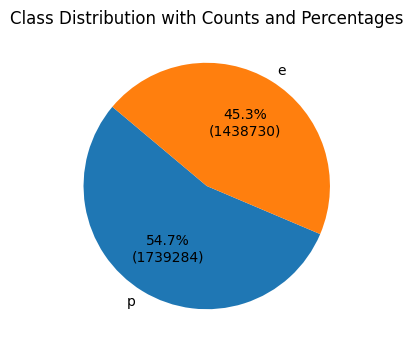

In [27]:
# Calculate the value counts and percentages
value_counts = df_train["class"].value_counts()
percentages = (value_counts / len(df_train)) * 100

# Combine the counts and percentages into a new DataFrame
result = pd.DataFrame({'count': value_counts, 'percentage': percentages})

# Plotting the pie chart
plt.figure(figsize=(6, 4))
plt.pie(result['count'], labels=result.index, autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, (p/100)*sum(result['count'])), startangle=140)

# Adding a title
plt.title('Class Distribution with Counts and Percentages')

# Displaying the plot
plt.show()

#### The class sizes are quite similar, so we probably won't need to use any balancing techniques.

## Data: Numerical

Metrical variables
1. cap-diameter (m): float number in cm
2. stem-height (m): float number in cm
3. stem-width (m): float number in mm

### Missing Values

In [30]:
df_train[['cap-diameter', 'stem-height', 'stem-width']].isna().sum()

cap-diameter    4
stem-height     0
stem-width      0
dtype: int64

In [29]:
df_test[['cap-diameter', 'stem-height', 'stem-width']].isna().sum()

cap-diameter    7
stem-height     1
stem-width      0
dtype: int64

#### In both, test and train dataset we have almost zero missing values (data sets of sizes 2-3 million). In both the test and train datasets, we have almost no missing values, which is great considering their sizes (2-3 million records). For the few missing values, we can fill them using the mean for numerical features.

In [31]:
#converting to numerical and fill missin with mean
def clean_numerical(df, list_numerical_features, test = False, df_train = None):
    """
    Cleans numerical features in a DataFrame by converting them to numeric types and handling missing values.

    This function iterates over a list of numerical features in a DataFrame, converting each feature to a numeric type.
    It then handles missing values by filling them with the mean of the respective column. If the function is applied to 
    a test dataset, missing values are filled using the mean from the corresponding training dataset column.

    Args:
        df (pd.DataFrame): The DataFrame containing the numerical features to clean.
        list_numerical_features (list of str): A list of column names representing numerical features to be cleaned.
        test (bool, optional): Indicates whether the DataFrame is a test dataset. Defaults to False.
        df_train (pd.DataFrame, optional): The training DataFrame used to fill missing values in the test DataFrame. 
                                           Required if `test` is True.

    Returns:
        pd.DataFrame: The DataFrame with cleaned numerical features.
    """
    for numerical_feature in list_numerical_features:
        df[numerical_feature] = pd.to_numeric(df[numerical_feature])
        if not test:
            df[numerical_feature] = pd.to_numeric(df[numerical_feature]).fillna(df[numerical_feature].mean())
        else:
            df[numerical_feature] = pd.to_numeric(df[numerical_feature]).fillna(df_train[numerical_feature].mean())
    return df

### Numerical data Distribution

In [34]:
numerical_columns = ['cap-diameter','stem-height', 'stem-height']

df_train = clean_numerical(df_train, numerical_columns)
df_test = clean_numerical(df_test, numerical_columns, True, df_train)

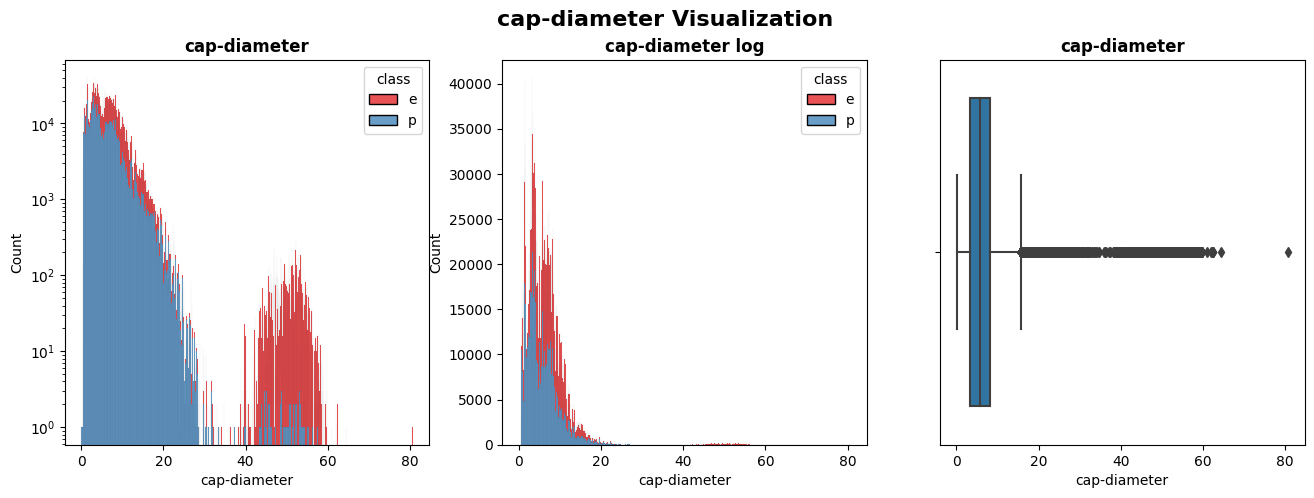

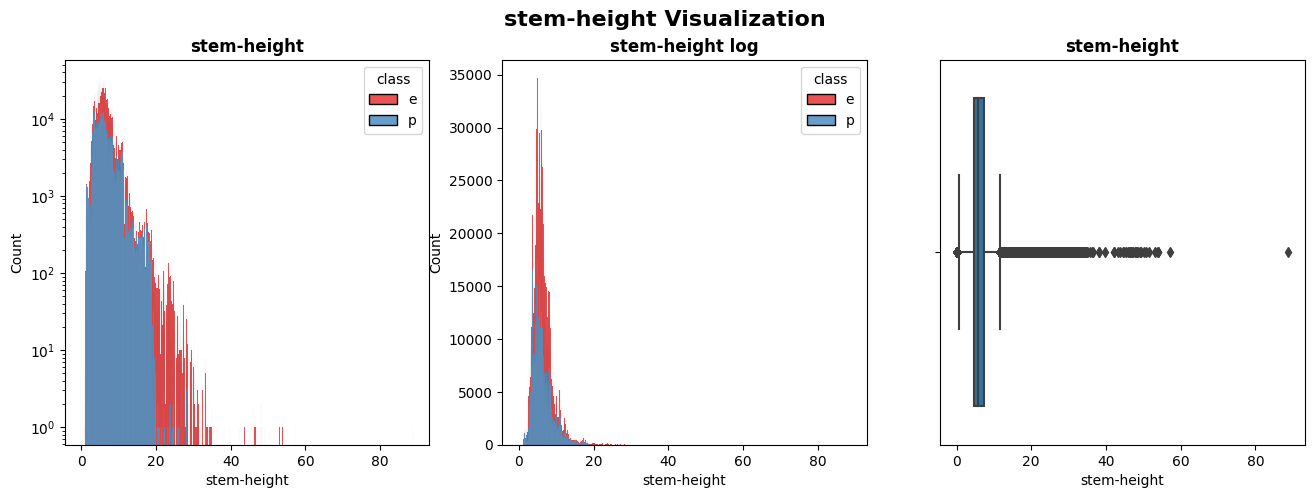

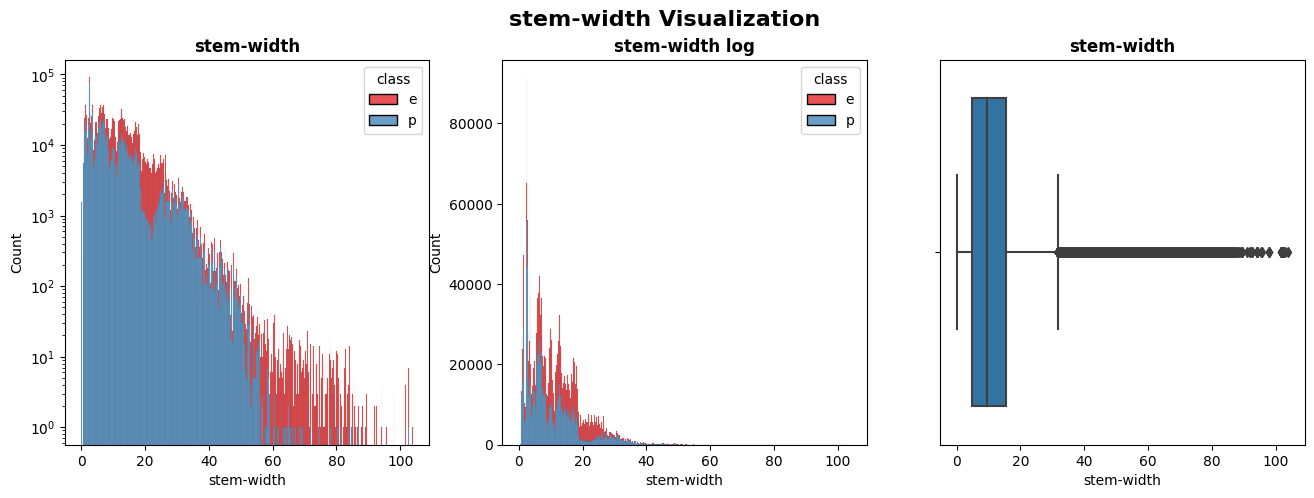

In [49]:
# Suppress warnings
warnings.filterwarnings('ignore')
# Visualize Numerical Variables with Color Differentiation for Classes

for column in numerical_features:
    f, ax = plt.subplots(1, 3, figsize=(16, 5))

    # Histogram with color differentiation by class
    sns.histplot(data=df_train, x=column, hue='class', multiple="stack", palette="Set1", log_scale=(False, True), ax=ax[0])
    sns.histplot(data=df_train, x=column, hue='class', multiple="stack", palette="Set1", log_scale=(False, False), ax=ax[1])  
    # Boxplot with color differentiation by class
    sns.boxplot(x=df_train[column], ax=ax[2])
    
    ax[0].set_title(f'{column}', fontsize=12, fontweight='bold')
    ax[1].set_title(f'{column} log', fontsize=12, fontweight='bold')
    ax[2].set_title(f'{column}', fontsize=12, fontweight='bold')
    
    plt.suptitle(f'{column} Visualization', fontsize=16, fontweight='bold')
    plt.show()

#### Based on the data distribution, we can observe that there are some outliers present, which we will address. There are noticeable differences between the classes, especially when using a logarithmic scale. However, it's important to note that these differences occur in regions with relatively few records. To handle the outliers, we will use the Interquartile Range (IQR) method and standard deviation.

In [45]:
# Function to detect outliers using the IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.01)
    Q3 = data[column].quantile(0.99)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]
for column in numerical_columns:
    outliers = detect_outliers_iqr(df_train, column)
    print(f"Number of outliers in {column}: {outliers.shape[0]}")

Number of outliers in cap-diameter: 11505
Number of outliers in stem-height: 35
Number of outliers in stem-height: 35


In [46]:
# Function to detect outliers using the standard deviation method
def detect_outliers_std(data, column, n_std = 4):
    mean = np.mean(data[column])
    std_dev = np.std(data[column])
    lower_bound = mean - n_std * std_dev
    upper_bound = mean + n_std * std_dev
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]
for column in numerical_columns:
    outliers = detect_outliers_std(df_train, column)
    print(f"Number of outliers in {column}: {outliers.shape[0]}")

Number of outliers in cap-diameter: 14150
Number of outliers in stem-height: 26282
Number of outliers in stem-height: 26282


In [47]:
# Function to remove outliers based on the chosen method
def remove_outliers(data, numerical_columns, method='iqr'):
    for column in numerical_columns:
        if method == 'iqr':
            outliers = detect_outliers_iqr(data, column)
        elif method == 'std':
            outliers = detect_outliers_std(data, column)
        else:
            raise ValueError("Invalid method specified. Choose 'iqr' or 'std'.")
        
        # Remove outliers from the dataframe
        data = data[~data.index.isin(outliers.index)]
    
    return data

#df_train = remove_outliers(df_train, numerical_columns, method='iqr')

#### I developed a method to remove outliers from datasets using the Interquartile Range (IQR) and Standard Deviation (STD) techniques.

#### Interquartile Range (IQR):
The IQR, also known as the midspread or middle 50%, is a measure of statistical dispersion. It represents the range within which the central half of the data points lie. Mathematically, it is calculated as the difference between the 75th percentile (Q3) and the 25th percentile (Q1), expressed as IQR = Q3 − Q1. In a box plot, this range can be visualized between the upper and lower quartiles. The IQR is a robust measure of spread, less sensitive to outliers compared to standard deviation or variance.

#### Standard Deviation (STD):
Standard deviation measures the average distance of each data point from the mean. It's typically used for normally distributed data as it assumes a symmetric spread around the mean.

#### However, after conducting some model training, I decided not to remove outliers. This decision was based on the observation that the testing data had a similar distribution to the training data. Removing data points can lead to a loss of valuable information, and retaining the outliers allowed the model to generalize better to unseen data.

## Data: Categorical
Seventeen remaining variables (n: nominal)
* cap-shape (n): bell=b, conical=c, convex=x, flat=f,sunken=s, spherical=p, others=o
* cap-surface (n): fibrous=i, grooves=g, scaly=y, smooth=s,shiny=h, leathery=l, silky=k, sticky=t,winkled=w, fleshy=e
* cap-color (n): brown=n, buff=b, gray=g, green=r, pink=p,purple=u, red=e, white=w, yellow=y, blue=l, orange=o, black=k
* does-bruise-bleed (n): bruises-or-bleeding=t,no=f
* gill-attachment (n): adnate=a, adnexed=x, decurrent=d, free=e, inuate=s, pores=p, none=f, unknown=?
* gill-spacing (n): close=c, distant=d, none=f
* gill-color (n): see cap-color + none=f
* stem-root (n): bulbous=b, swollen=s, club=c, cup=u, equal=e, hizomorphs=z, rooted=r
* stem-surface (n): see cap-surface + none=f
* stem-color (n): see cap-color + none=f
* veil-type (n): partial=p, universal=u
* veil-color (n): see cap-color + none=f
* has-ring (n): ring=t, none=f
* ring-type (n): cobwebby=c, evanescent=e, flaring=r, grooved=g, large=l, pendant=p, sheathing=s, zone=z, scaly=y, movable=m, none=f, unknown=?
* spore-print-color (n): see cap color
* habitat (n): grasses=g, leaves=l, meadows=m, paths=p, heaths=h, urban=u, waste=w, woods=d
* season (n): spring=s, summer=u, autumn=a, winter=w

In [50]:
df_train[categorical_features].isna().sum()

cap-shape                    40
cap-surface              685143
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          533820
gill-spacing            1283498
gill-color                   57
stem-root               2808561
stem-surface            2018985
stem-color                   38
veil-type               3015385
veil-color              2794603
has-ring                     24
ring-type                131351
spore-print-color       2904397
habitat                      45
season                        0
dtype: int64

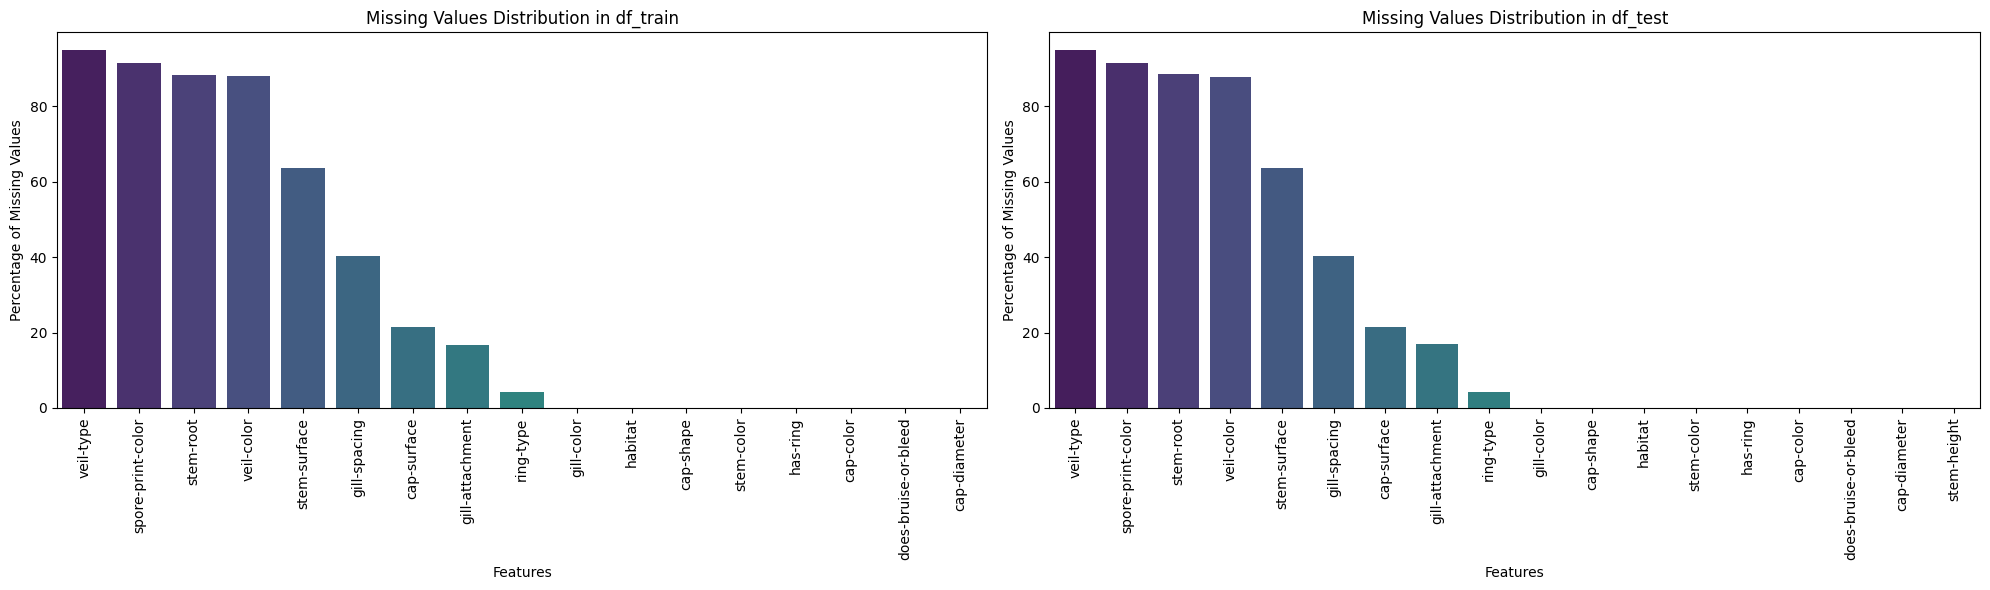

In [15]:
missing_values_train = df_train.isnull().mean() * 100
missing_values_train = missing_values_train[missing_values_train >0]
missing_values_train = missing_values_train.sort_values(ascending=False)

missing_values_test = df_test.isnull().mean() * 100
missing_values_test = missing_values_test[missing_values_test >0]
missing_values_test = missing_values_test.sort_values(ascending=False)

# Create the figure and two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # 1 row, 2 columns

# Plot the first bar plot on the first subplot
sns.barplot(x=missing_values_train.index, y=missing_values_train.values, palette='viridis', ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Percentage of Missing Values')
axes[0].set_title('Missing Values Distribution in df_train')

# Plot the second bar plot on the second subplot
sns.barplot(x=missing_values_test.index, y=missing_values_test.values, palette='viridis', ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Percentage of Missing Values')
axes[1].set_title('Missing Values Distribution in df_test')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

#### The missing values are distributed similarly across the dataset. Some columns have over 50% missing data, which needs to be addressed. Rather than dropping these columns and losing potentially important information, we will handle this by adding a 'missing' category to retain as much data as possible.

### Categorical data Distribution

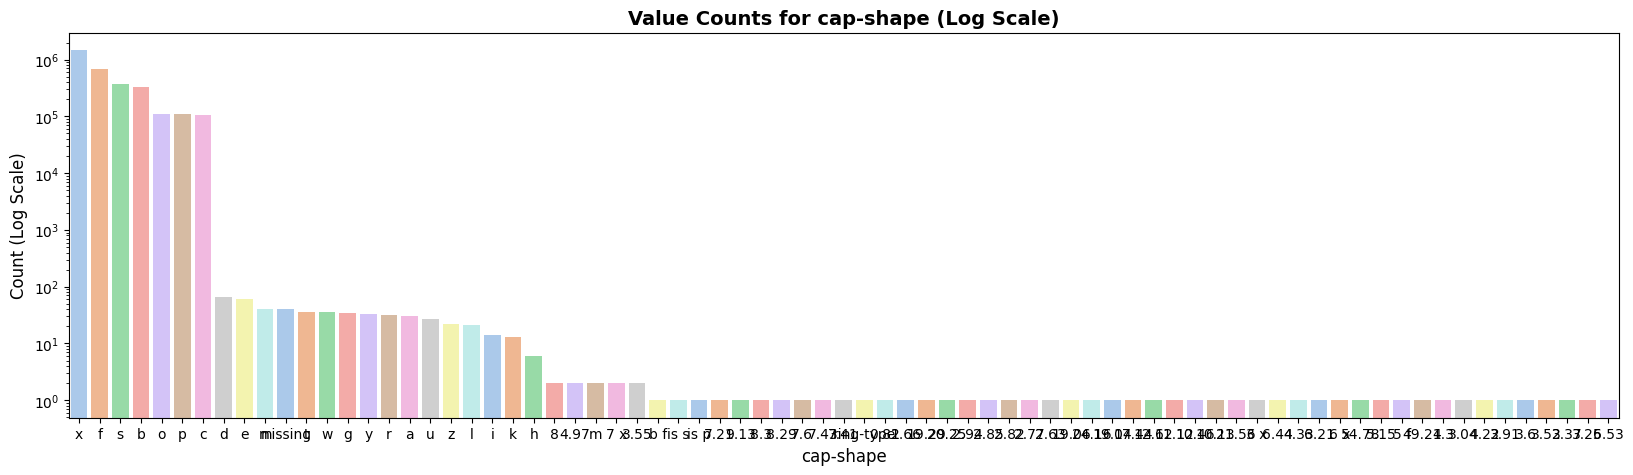

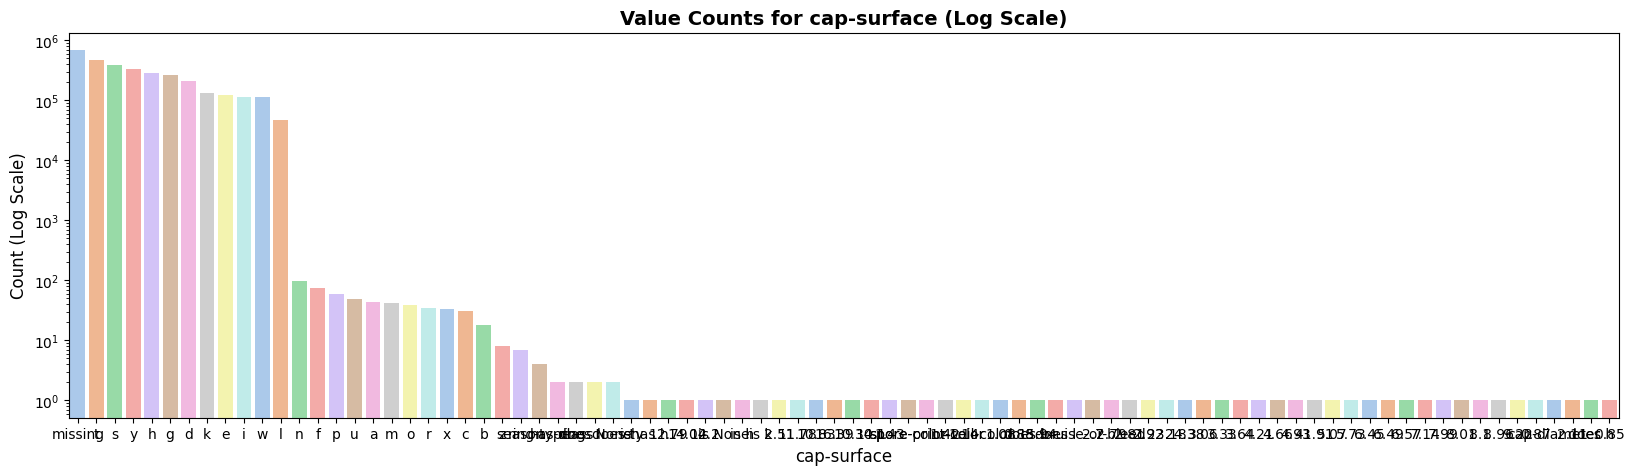

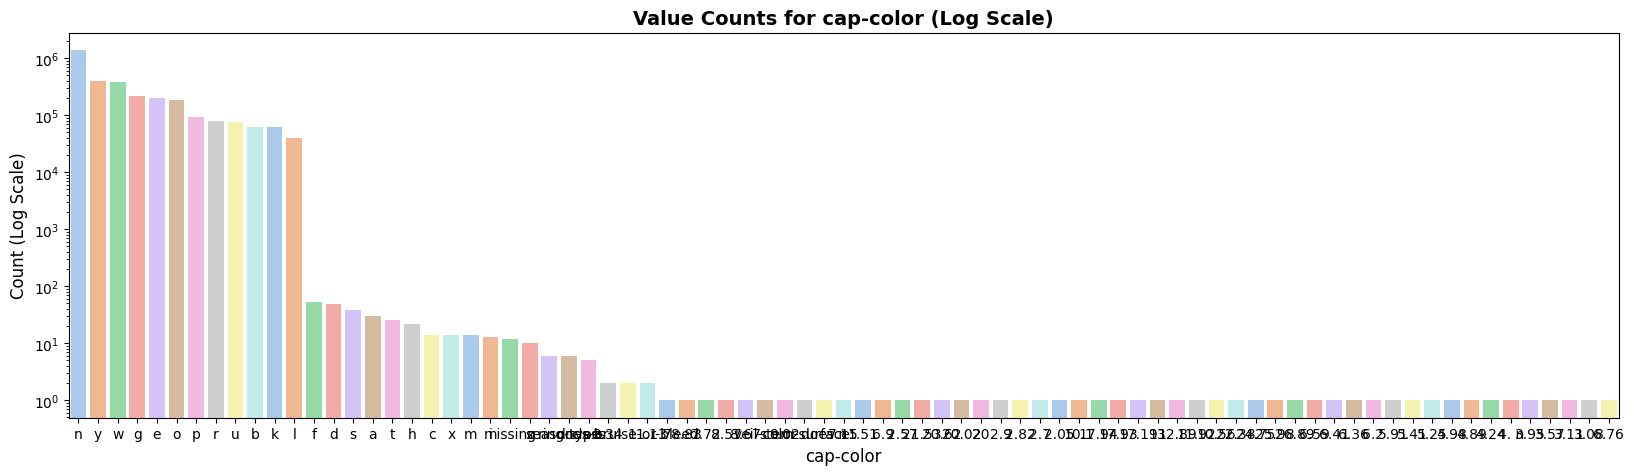

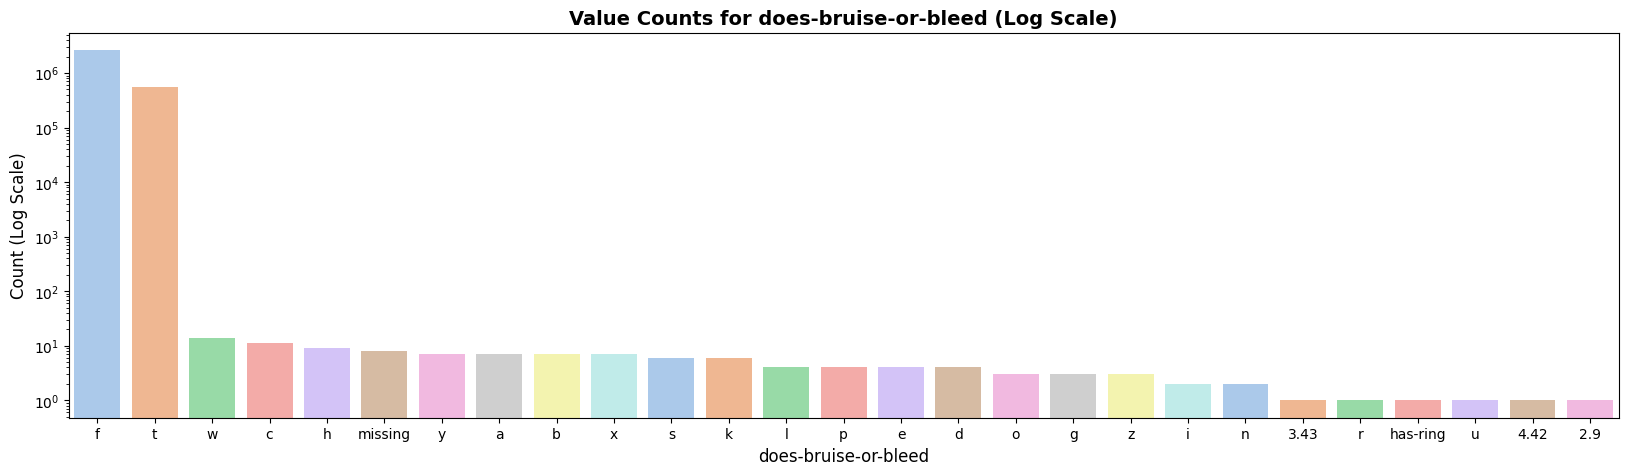

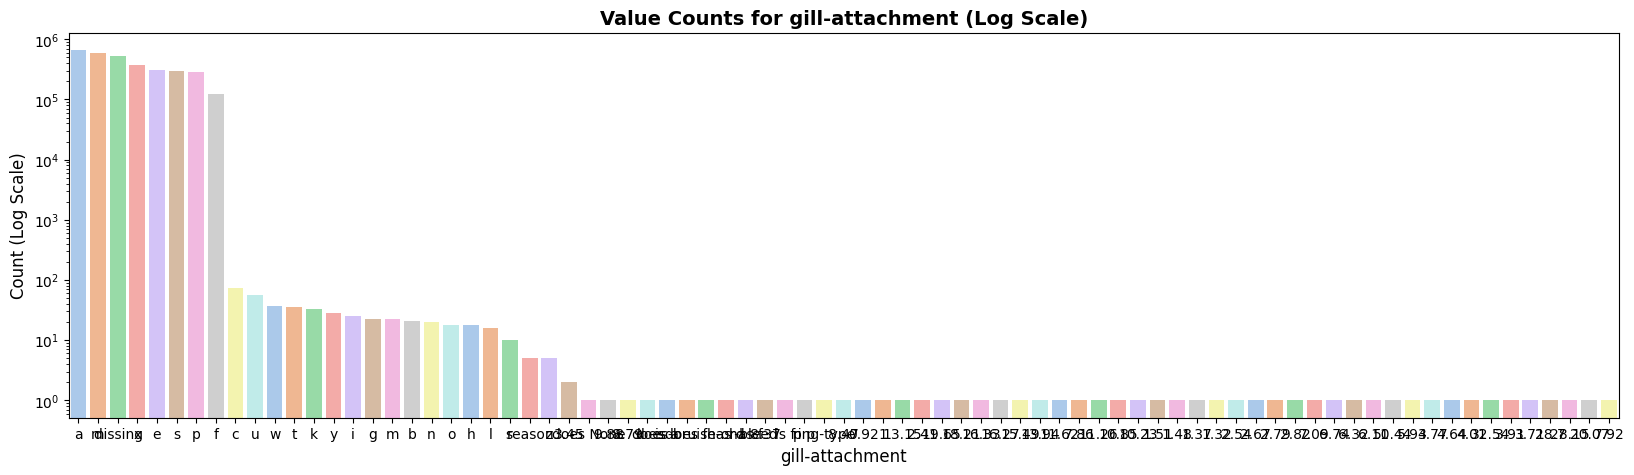

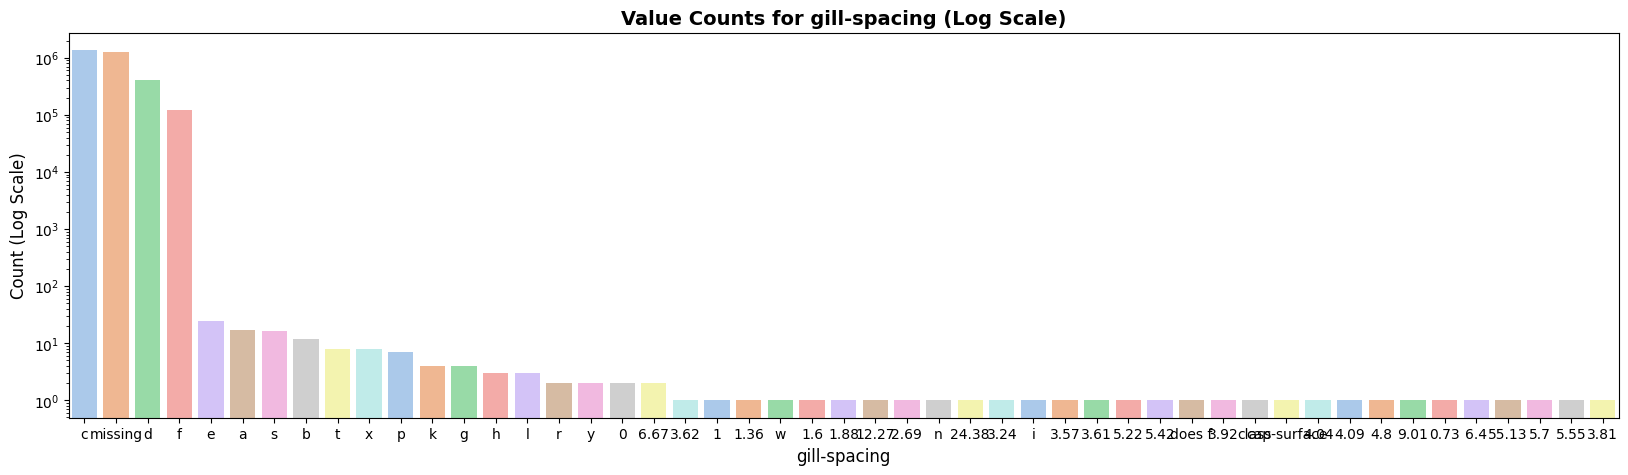

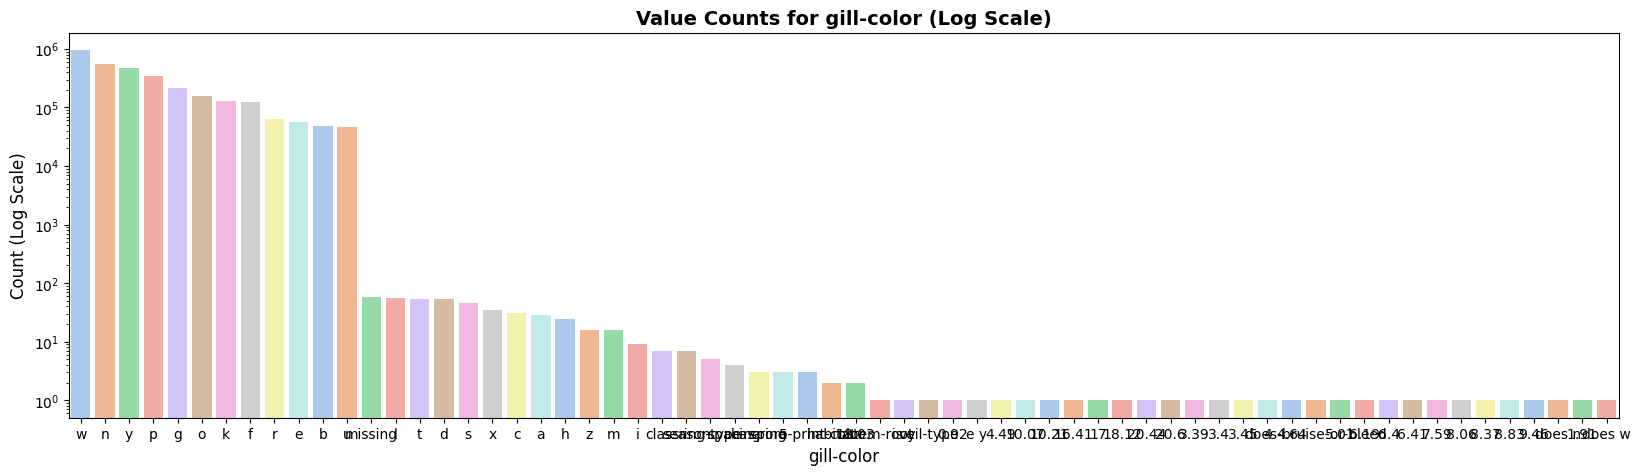

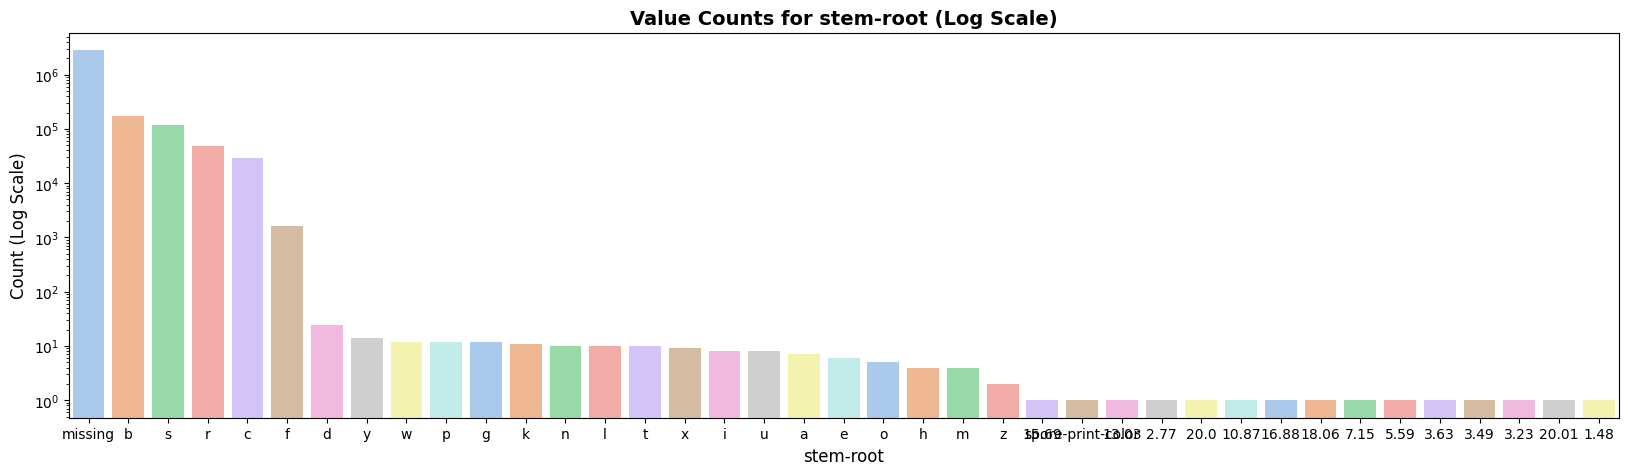

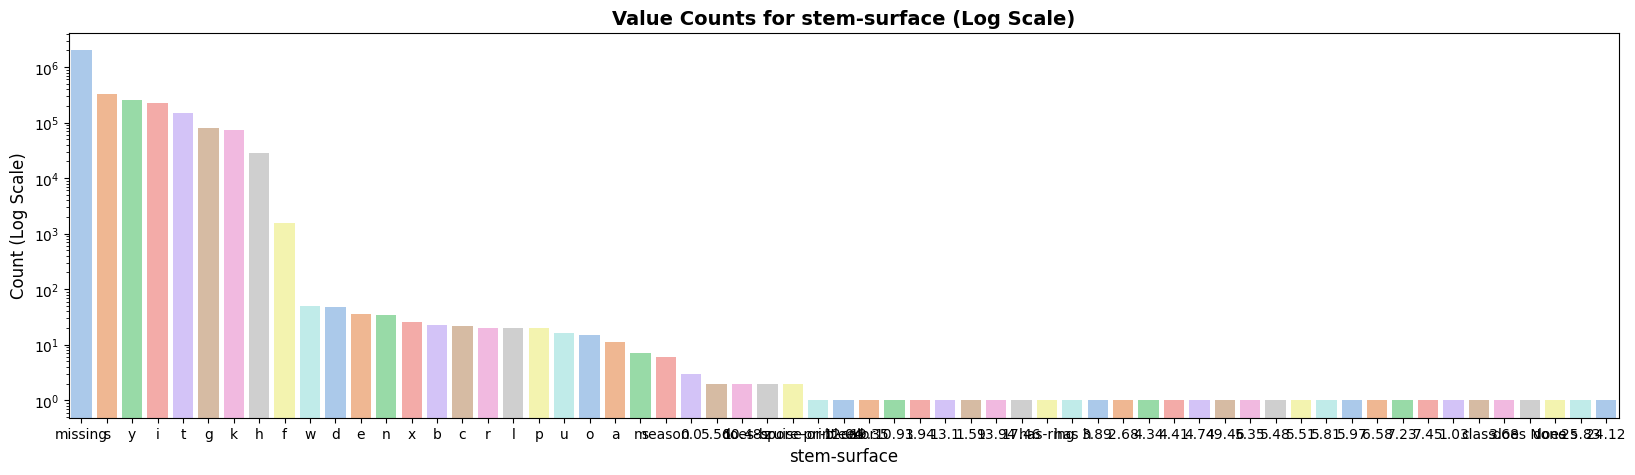

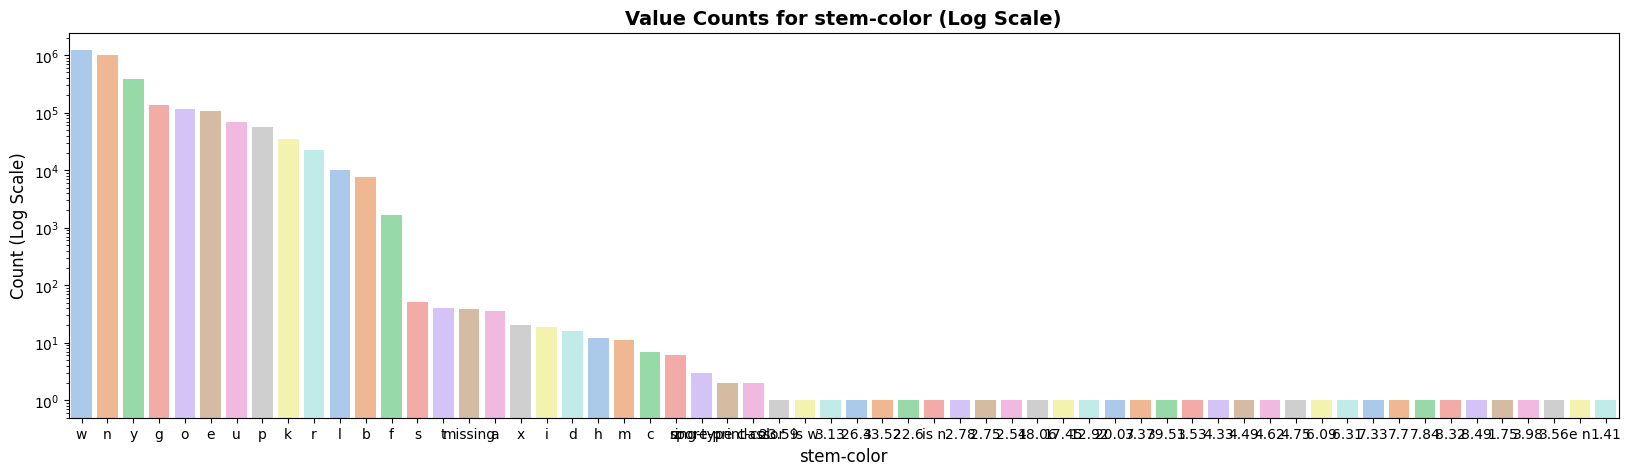

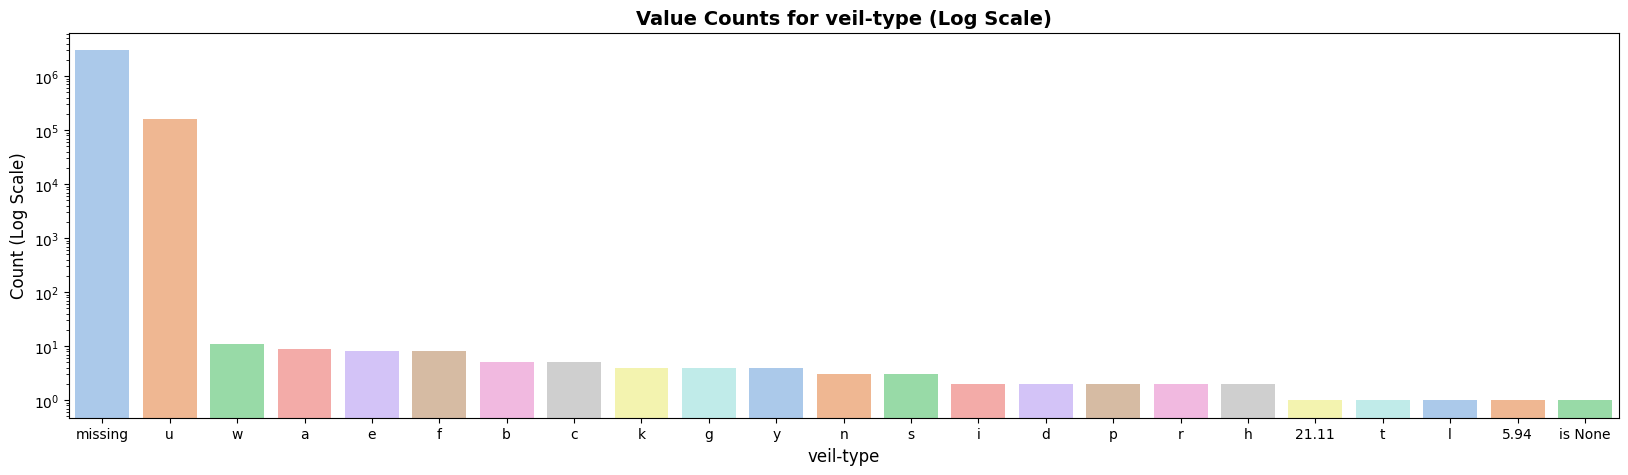

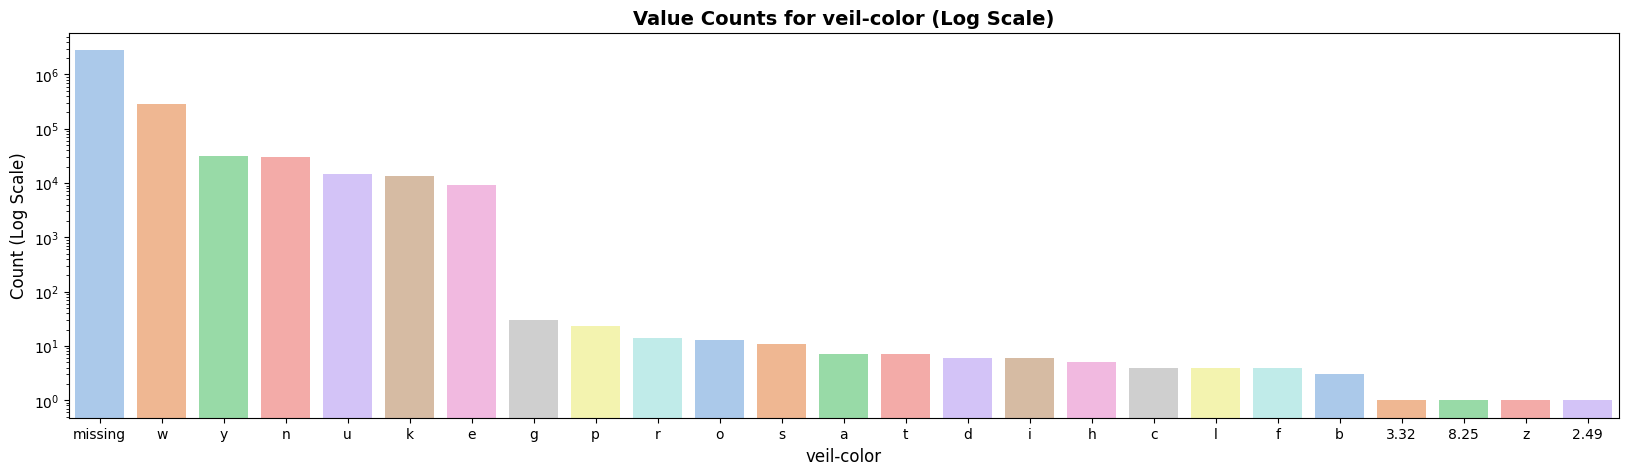

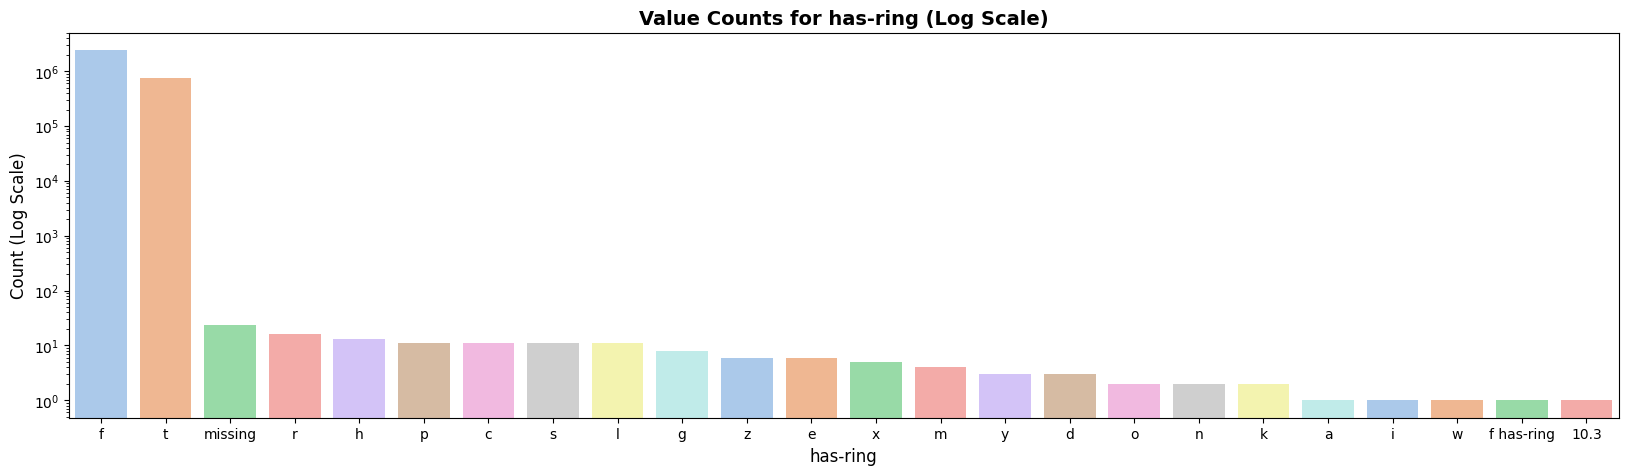

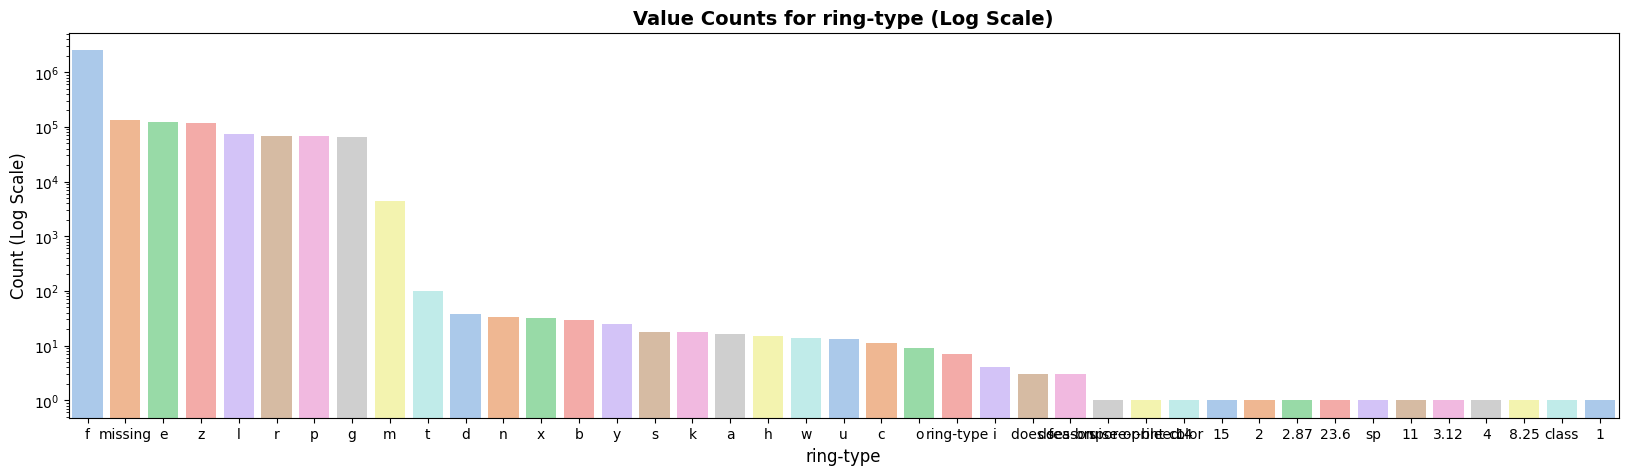

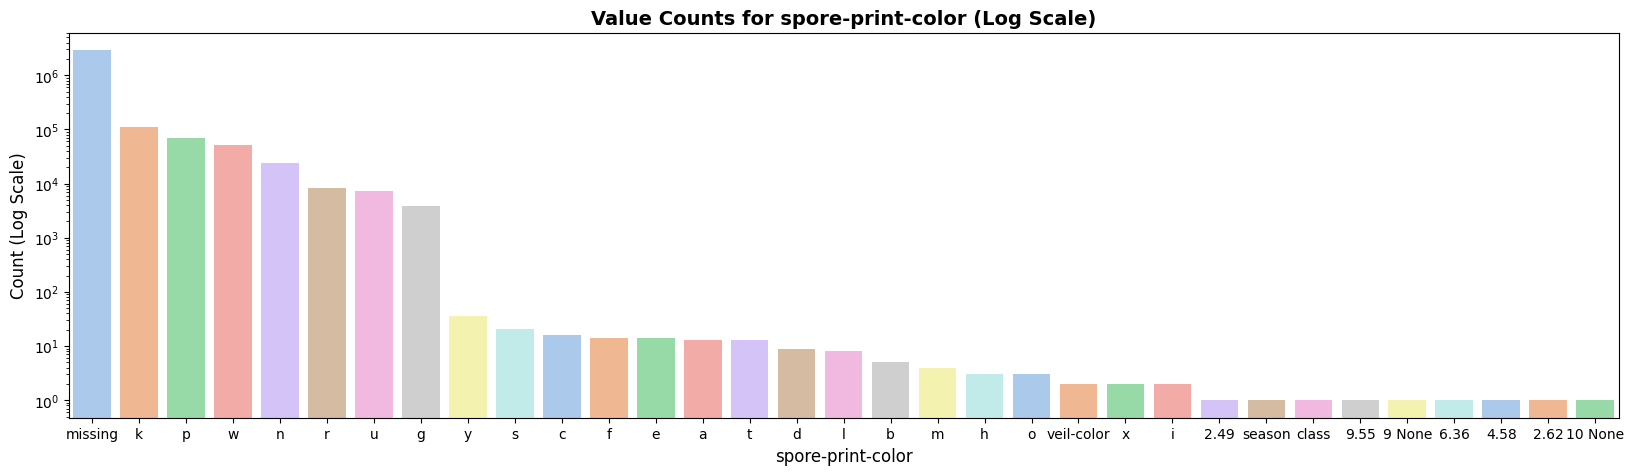

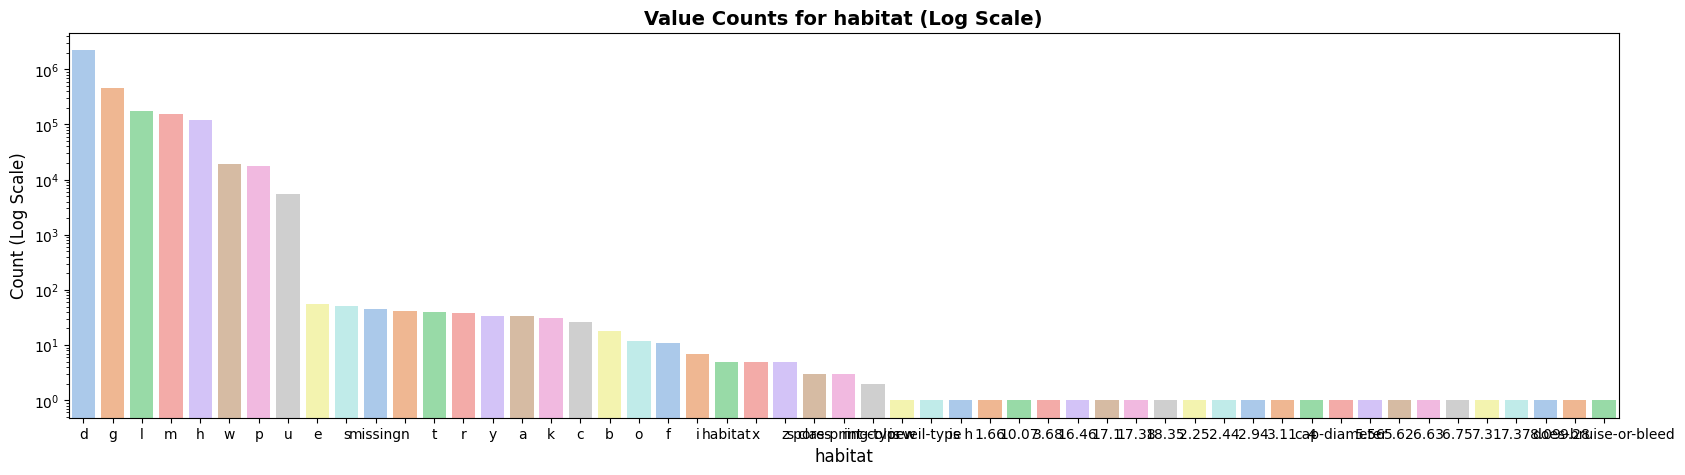

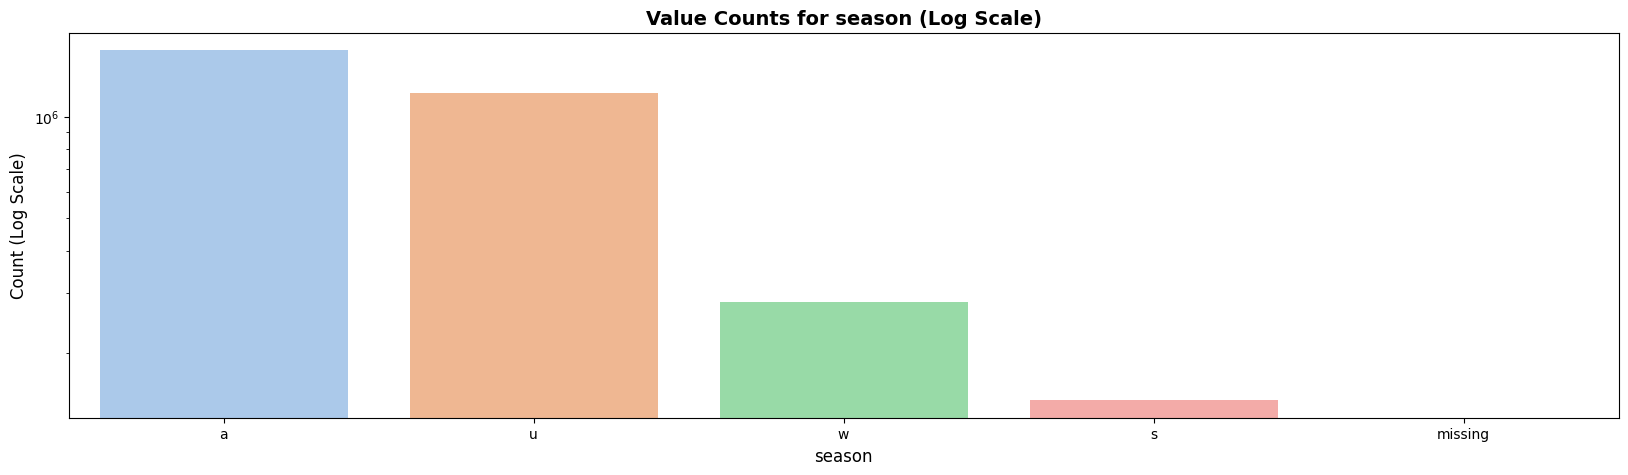

In [55]:
# Visualize Categorical Variables with Histograms of Value Counts in Log Scale Including NaNs and Sorted
for column in categorical_features:
    plt.figure(figsize=(20, 5))
    
    # Convert NaNs to 'missing' for visualization
    df_train[column] = df_train[column].astype('category')
    #df_train[column] = df_train[column].cat.add_categories('missing')
    df_train[column] = df_train[column].fillna('missing')
    
    # Sort categories by count
    sorted_categories = df_train[column].value_counts().index
    
    # Plotting the count plot for each categorical feature with log scale, NaNs included, and sorted
    sns.countplot(data=df_train, x=column, palette="pastel", order=sorted_categories)
    
    # Setting y-axis to log scale
    plt.yscale('log')
    
    # Setting the title and labels
    plt.title(f'Value Counts for {column} (Log Scale)', fontsize=14, fontweight='bold')
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Count (Log Scale)', fontsize=12)
    
    # Display the plot
    plt.show()

#### We have a lot of irrelevant or nonsensical data that needs to be addressed. We will clean the data based on the dataset's description. Data that is not significant will be categorized as 'noise', and any NaN values will be labeled as 'missing'.

In [65]:
# treating nonsensical categories and missing values
categories = {
    'cap-shape': ['b', 'c', 'x', 'f', 's', 'p', 'o'],
    'cap-surface': ['i', 'g', 'y', 's', 'h', 'l', 'k', 't', 'w', 'e'],
    'cap-color': ['n', 'b', 'g', 'r', 'p', 'u', 'e', 'w', 'y', 'l', 'o', 'k'],
    'does-bruise-or-bleed': ['t', 'f'],
    'gill-attachment': ['a', 'x', 'd', 'e', 's', 'p', 'f', '?'],
    'gill-spacing': ['c', 'd', 'f'],
    'gill-color': ['n', 'b', 'g', 'r', 'p', 'u', 'e', 'w', 'y', 'l', 'o', 'k', 'f'],  # Same as cap-color plus 'f'
    'stem-root': ['b', 's', 'c', 'u', 'e', 'z', 'r'],
    'stem-surface': ['i', 'g', 'y', 's', 'h', 'l', 'k', 't', 'w', 'e', 'f'],  # Same as cap-surface plus 'f'
    'stem-color': ['n', 'b', 'g', 'r', 'p', 'u', 'e', 'w', 'y', 'l', 'o', 'k', 'f'],  # Same as cap-color plus 'f'
    'veil-type': ['p', 'u'],
    'veil-color': ['n', 'b', 'g', 'r', 'p', 'u', 'e', 'w', 'y', 'l', 'o', 'k', 'f'],  # Same as cap-color plus 'f'
    'has-ring': ['t', 'f'],
    'ring-type': ['c', 'e', 'r', 'g', 'l', 'p', 's', 'z', 'y', 'm', 'f', '?'],
    'spore-print-color': ['n', 'b', 'g', 'r', 'p', 'u', 'e', 'w', 'y', 'l', 'o', 'k'],  # Same as cap-color
    'habitat': ['g', 'l', 'm', 'p', 'h', 'u', 'w', 'd'],
    'season': ['s', 'u', 'a', 'w']
}

# function to deal with missing and nonsensical values
def clean_cats(string):
    if pd.isna(string):
        return 'missing'
    elif type(string)!=str:
        return 'missing'
    ans=None
    words=string.split()
    for word in words:
        word = re.sub(r'[^a-zA-Z?]', '', word)
        if len(word)==1:
            ans=word
    if ans == None or ans=='':
        ans='missing'
    return ans

In [66]:
def clean_categorical(df):
    for column in df.columns:
        if df[column].dtype=='category' and column!='class':
            main_cats = categories[column]+['missing']
            df[column] = df[column].apply(lambda x: clean_cats(x))
            df[column] = df[column].apply(lambda x: x if x in main_cats else 'noise')
            df[column] = df[column] .astype('category')
    return df

In [67]:
df_train = clean_categorical(df_train)

In [68]:
df_train

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,e,8.80,f,s,u,f,a,c,w,4.51,...,missing,missing,w,missing,missing,f,f,missing,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,missing,y,o,missing,missing,t,z,missing,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,missing,s,n,missing,missing,f,f,missing,l,w
3,e,3.88,f,y,g,f,s,missing,g,4.16,...,missing,missing,w,missing,missing,f,f,missing,d,u
4,e,5.85,x,l,w,f,d,missing,w,3.37,...,missing,missing,w,missing,missing,f,f,missing,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3178009,p,1.18,s,s,y,f,f,f,f,3.93,...,missing,missing,y,missing,missing,f,f,missing,d,a
3178010,p,1.27,f,s,y,f,f,f,f,3.18,...,missing,missing,y,missing,missing,f,f,missing,d,a
3178011,p,1.27,s,s,y,f,f,f,f,3.86,...,missing,missing,y,missing,missing,f,f,missing,d,u
3178012,p,1.24,f,s,y,f,f,f,f,3.56,...,missing,missing,y,missing,missing,f,f,missing,d,u


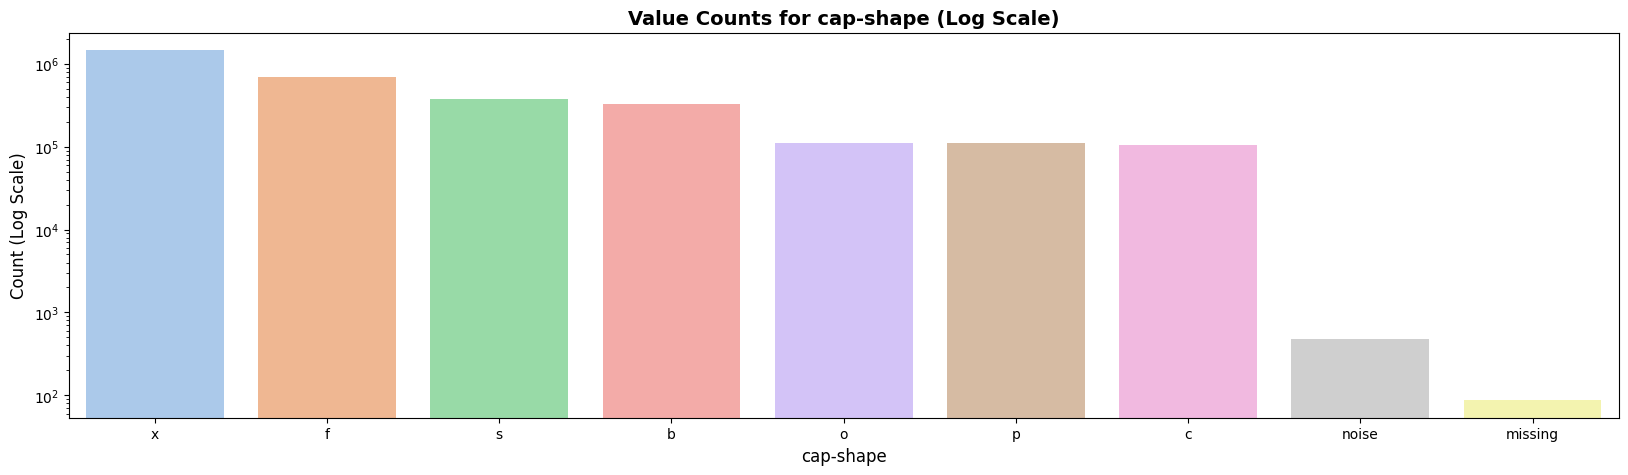

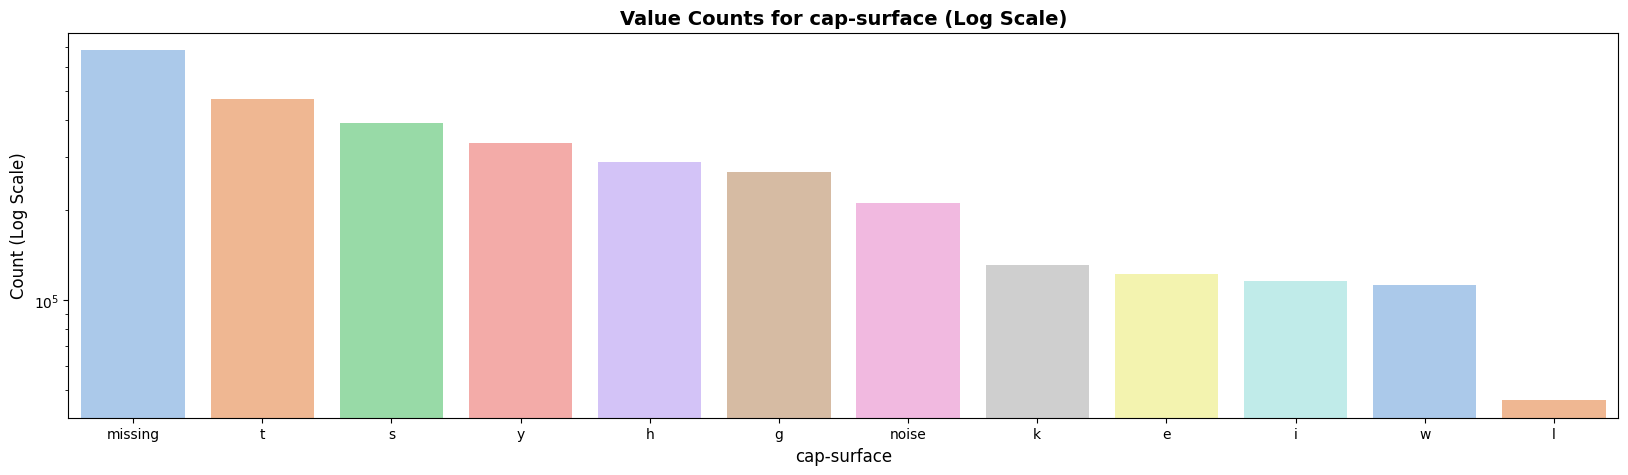

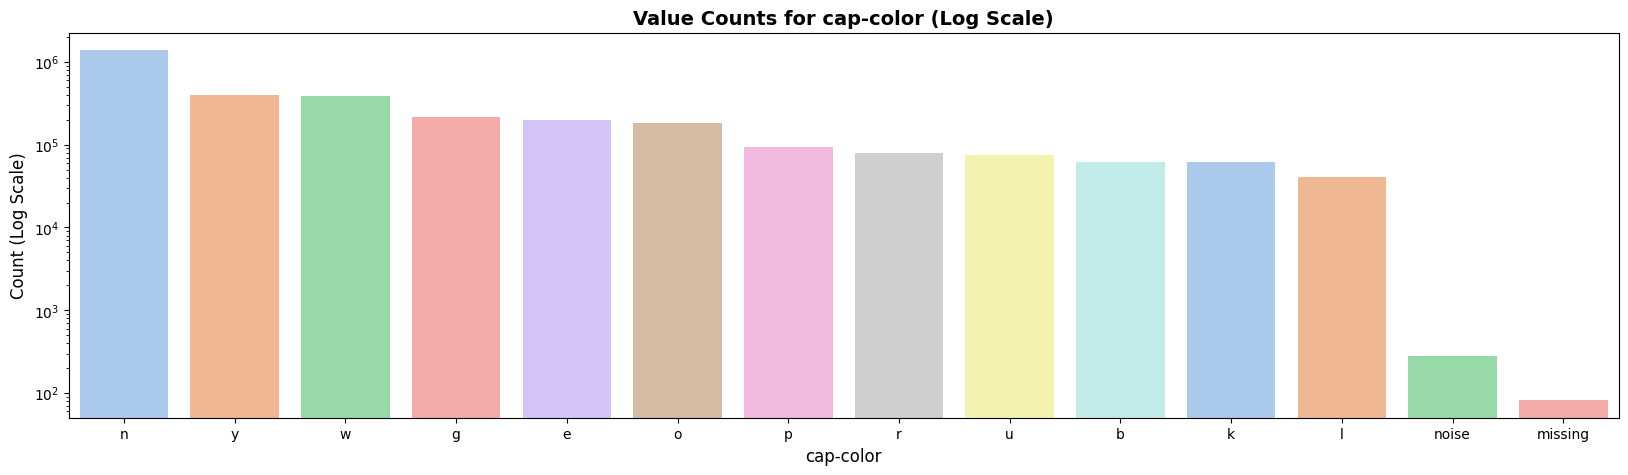

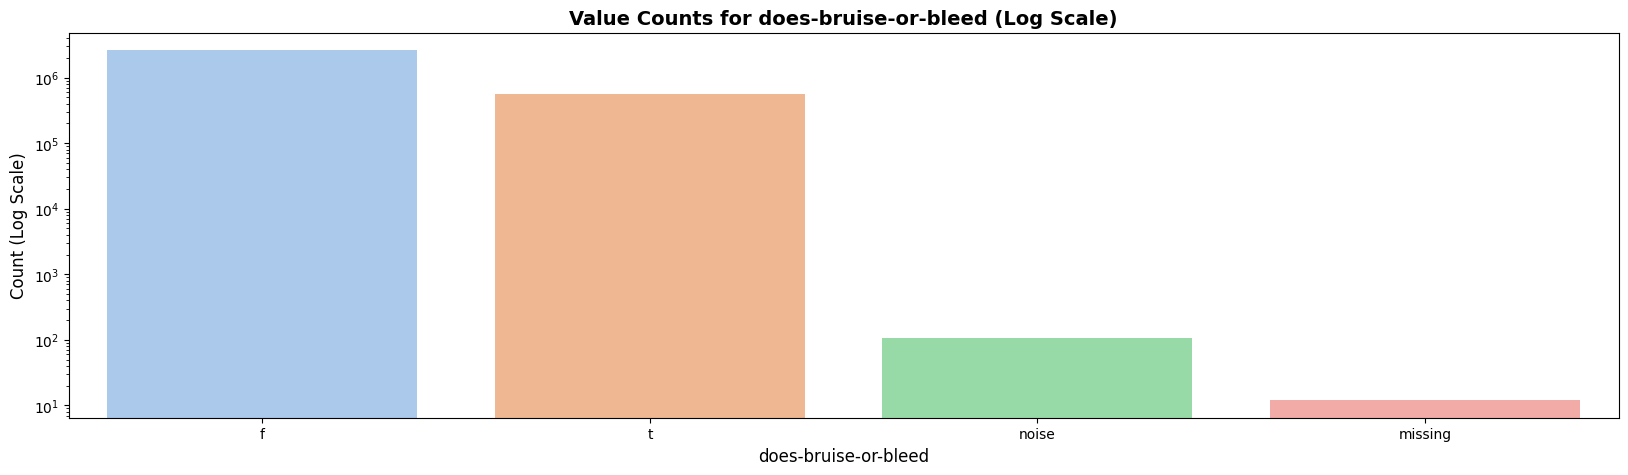

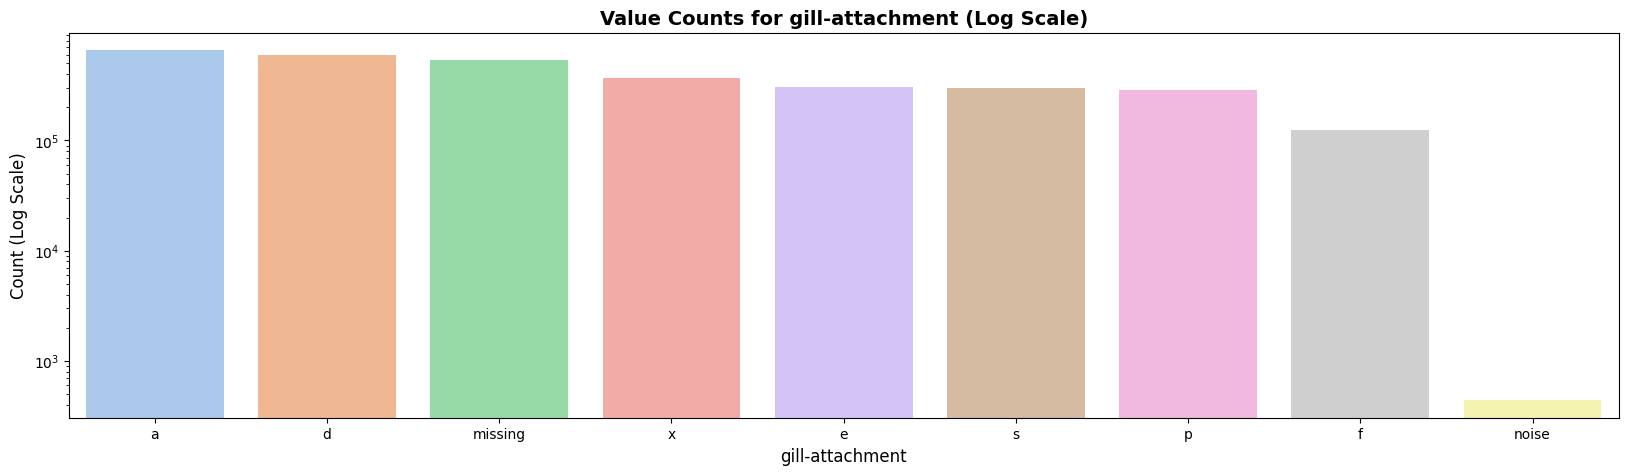

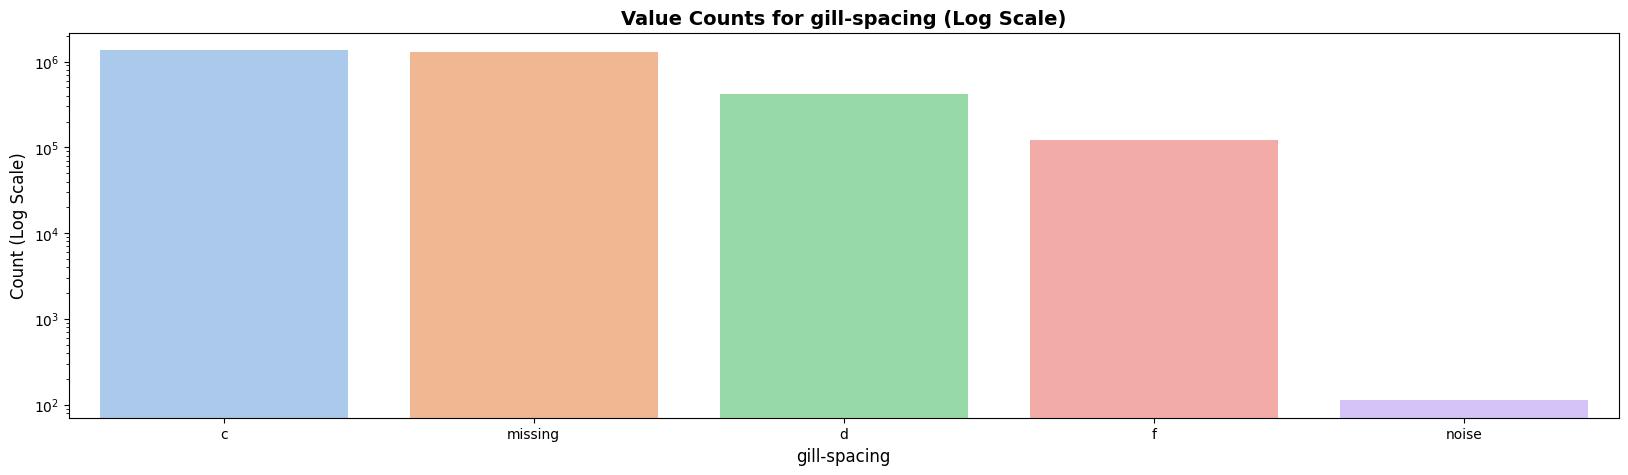

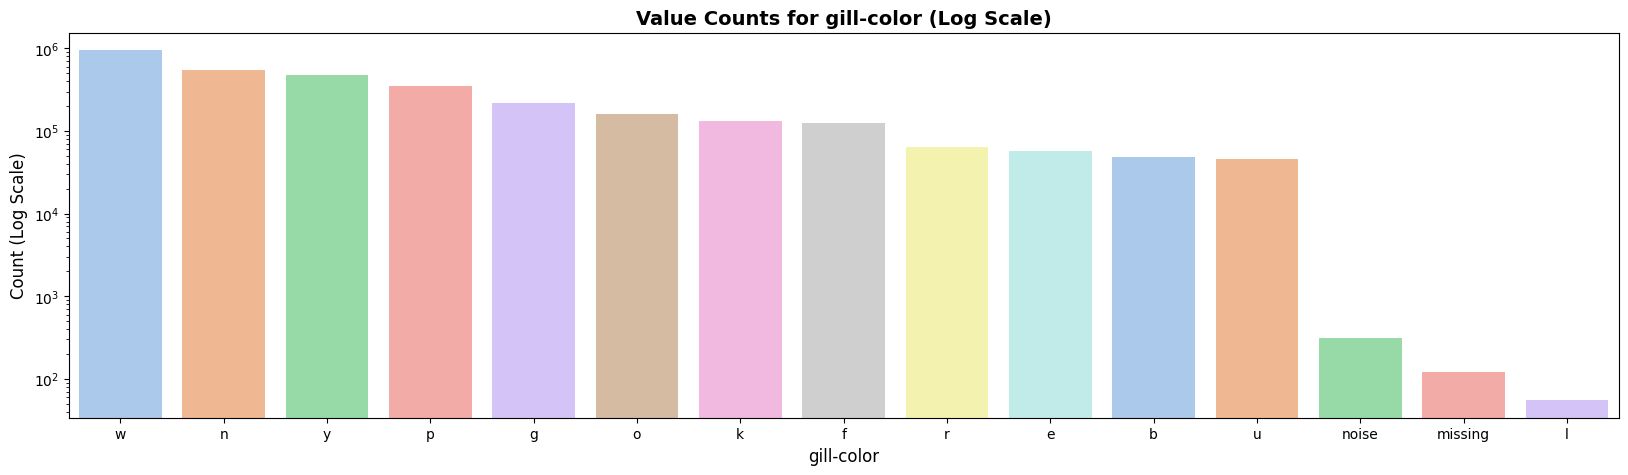

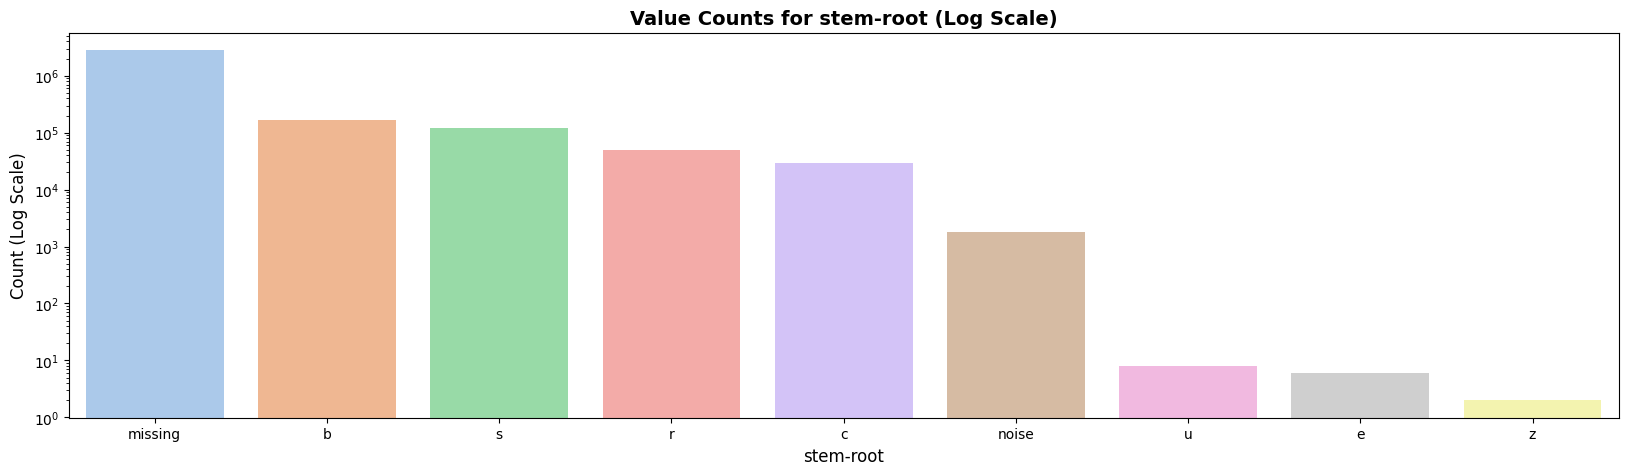

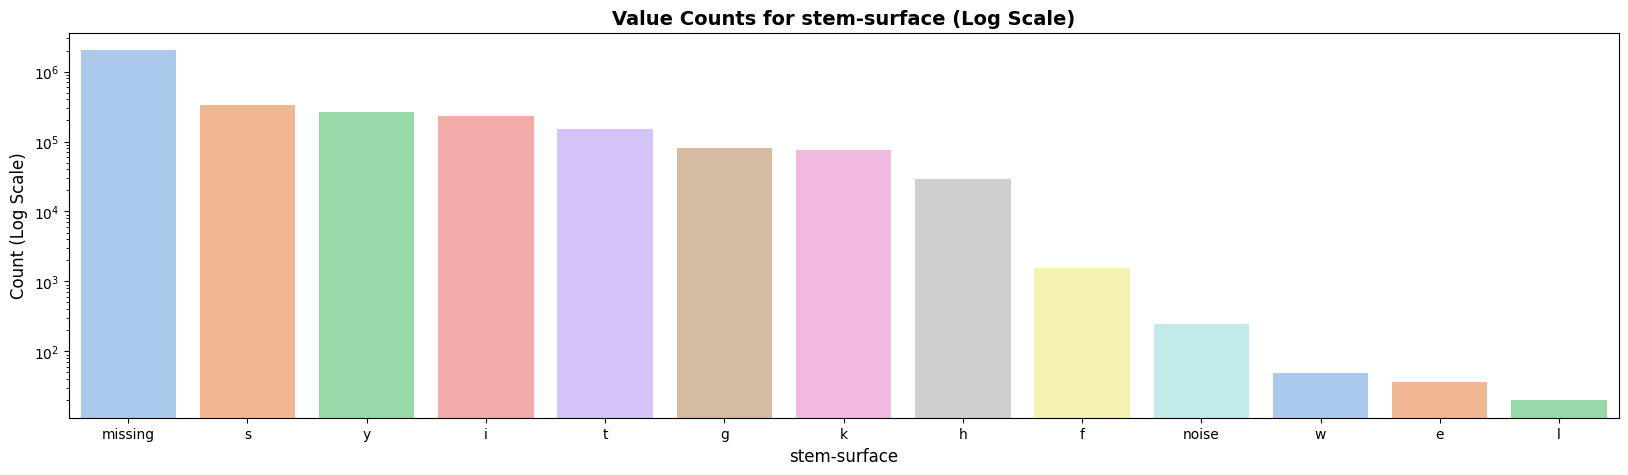

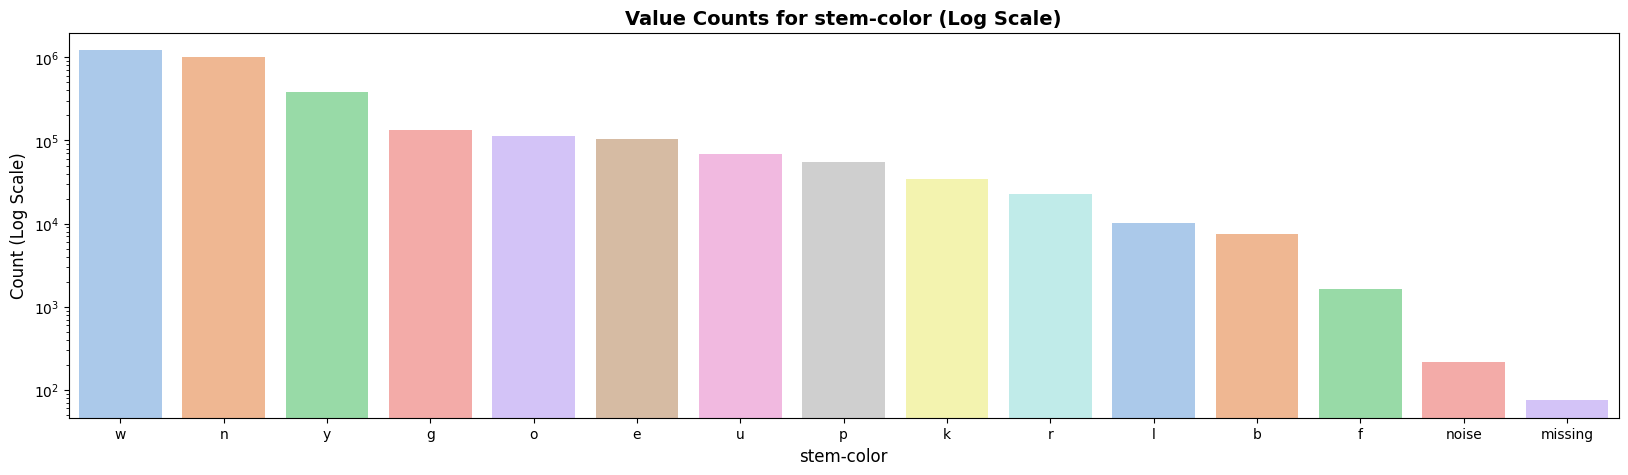

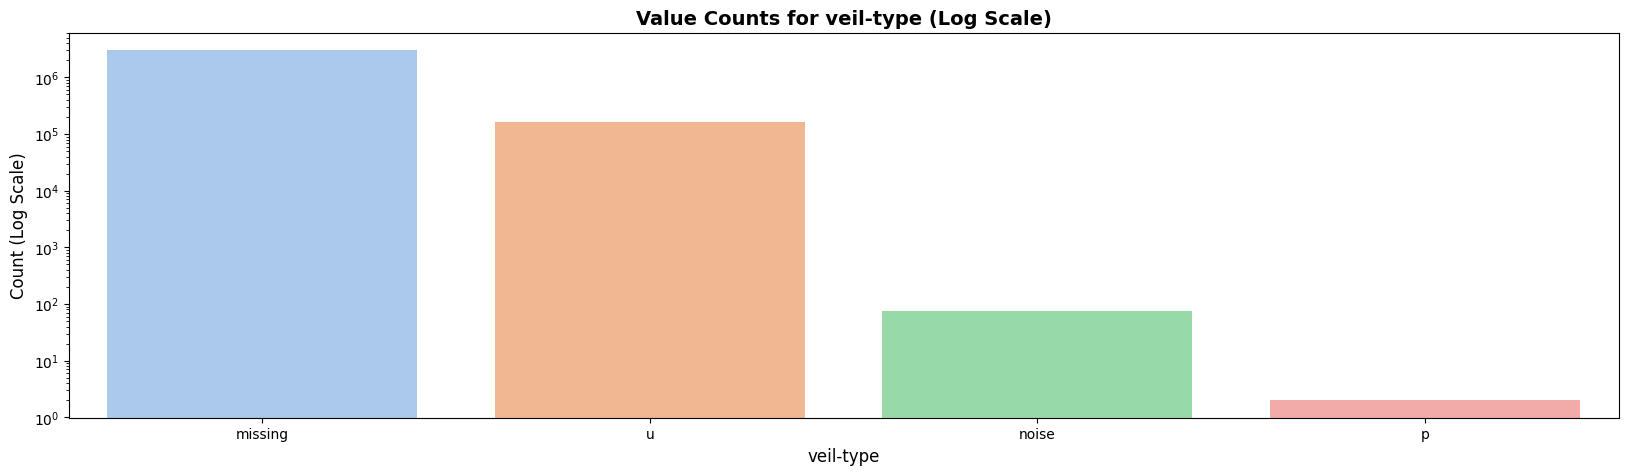

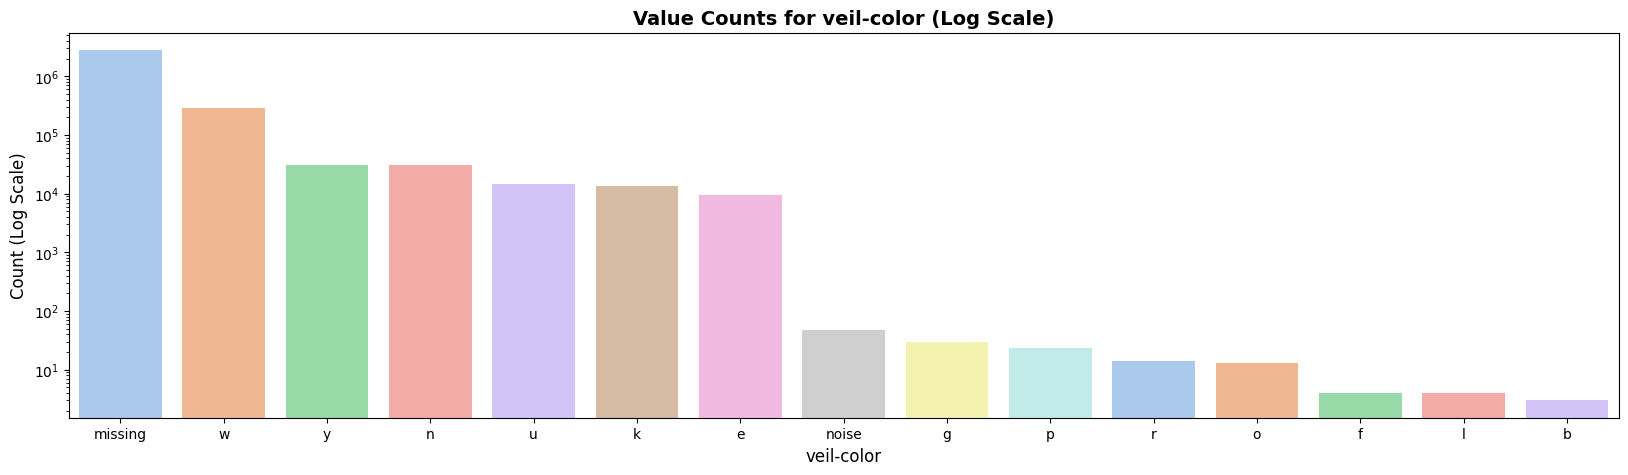

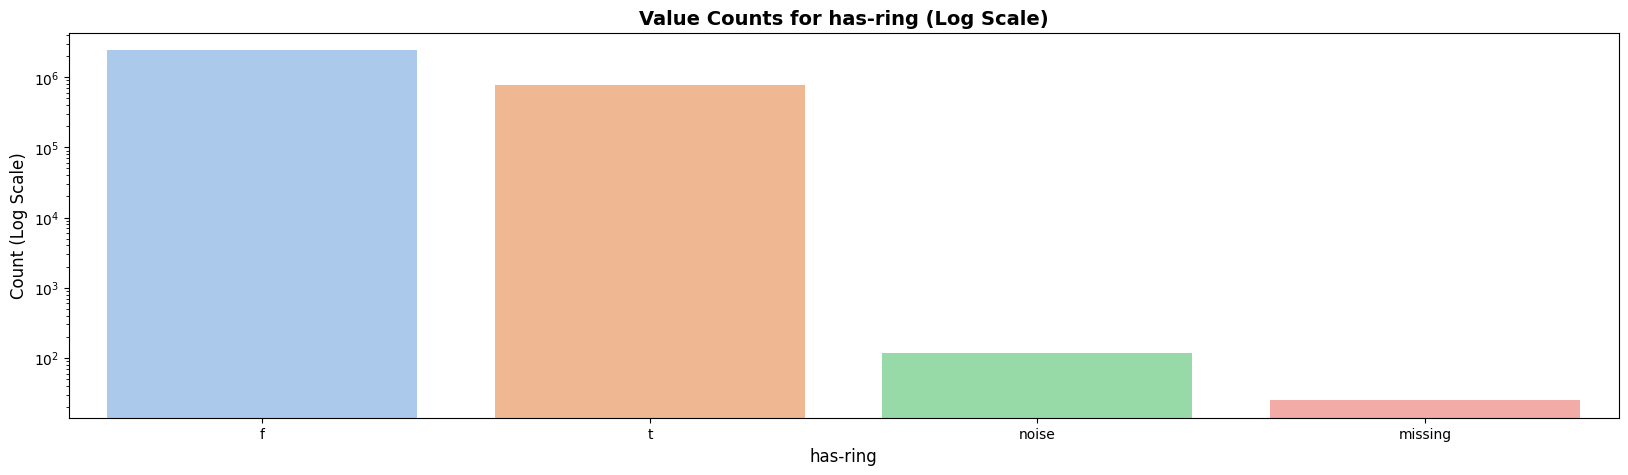

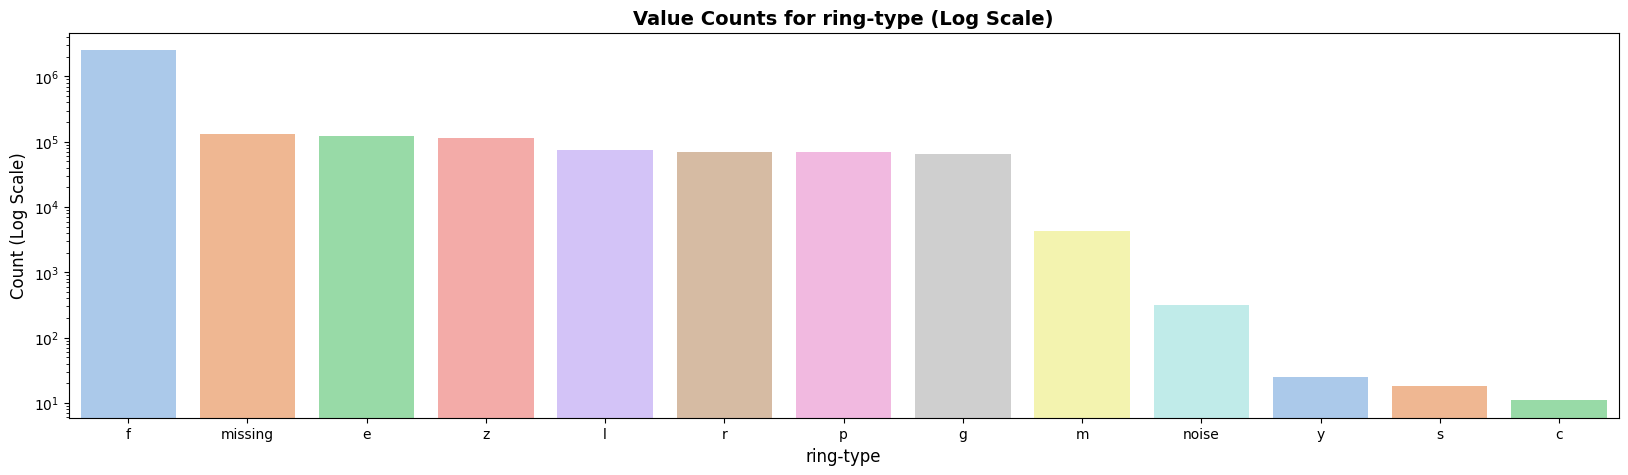

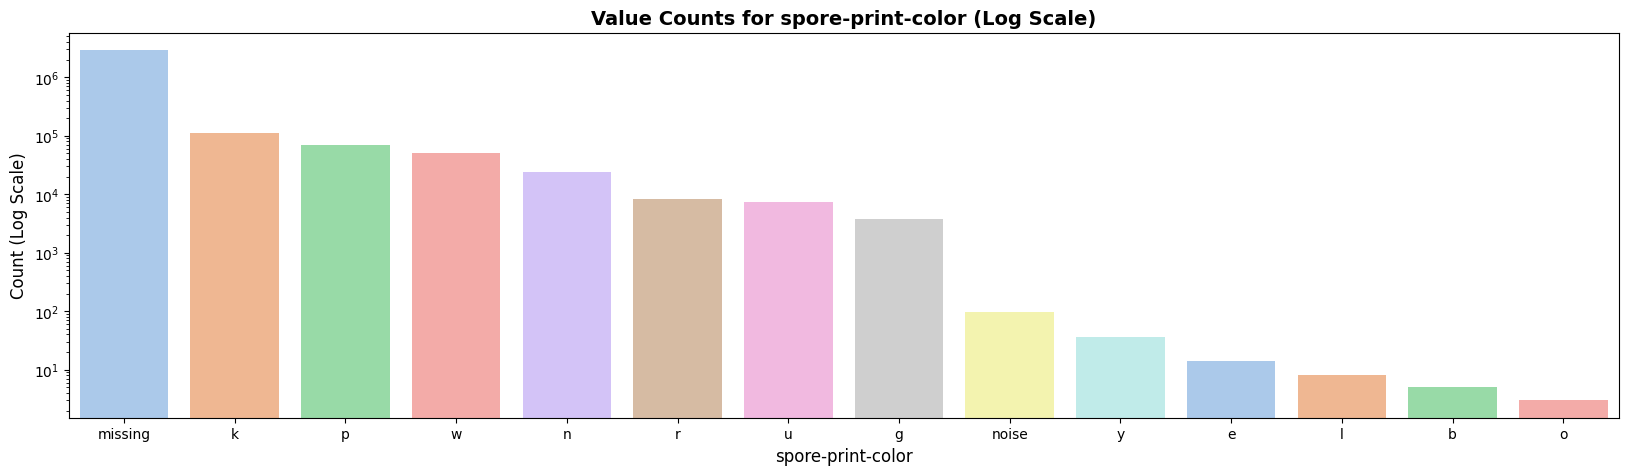

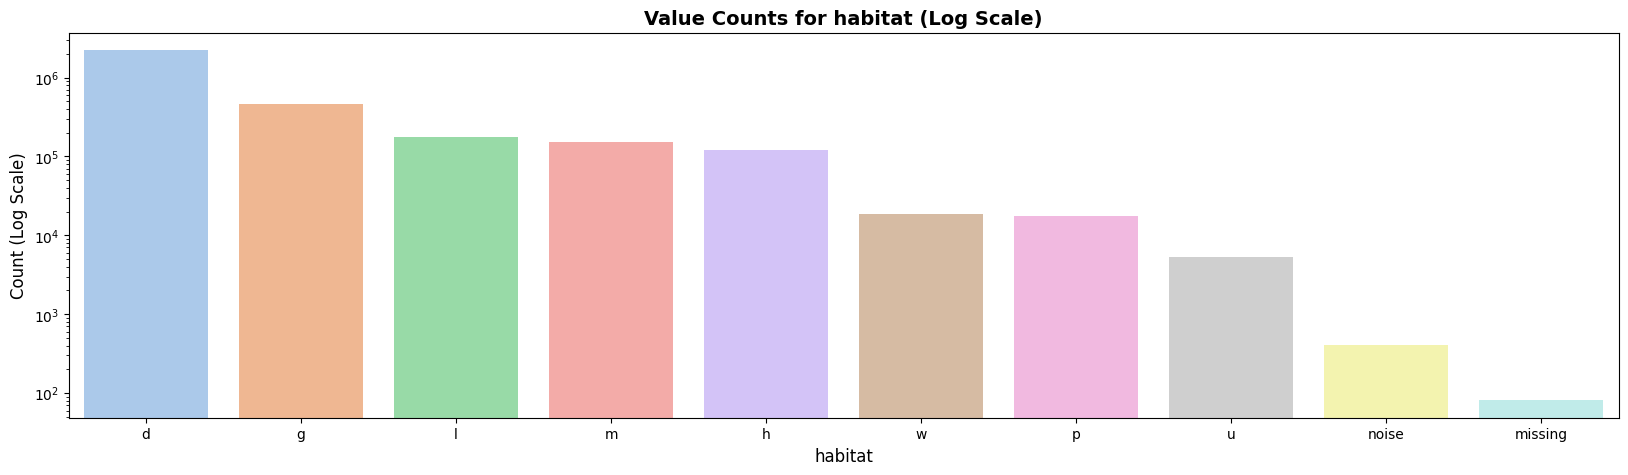

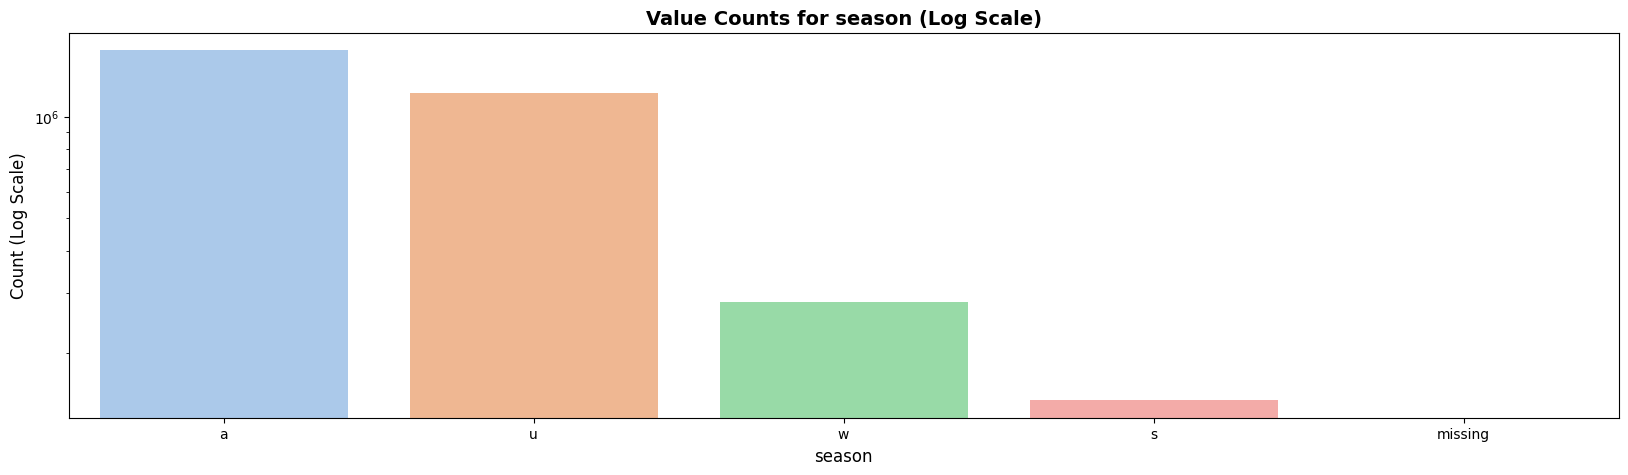

In [69]:
# Visualize Categorical Variables with Histograms of Value Counts in Log Scale Including NaNs and Sorted
for column in categorical_features:
    plt.figure(figsize=(20, 5))
    
    # Convert NaNs to 'missing' for visualization
    df_train[column] = df_train[column].astype('category')
    #df_train[column] = df_train[column].cat.add_categories('missing')
    df_train[column] = df_train[column].fillna('missing')
    
    # Sort categories by count
    sorted_categories = df_train[column].value_counts().index
    
    # Plotting the count plot for each categorical feature with log scale, NaNs included, and sorted
    sns.countplot(data=df_train, x=column, palette="pastel", order=sorted_categories)
    
    # Setting y-axis to log scale
    plt.yscale('log')
    
    # Setting the title and labels
    plt.title(f'Value Counts for {column} (Log Scale)', fontsize=14, fontweight='bold')
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Count (Log Scale)', fontsize=12)
    
    # Display the plot
    plt.show()

#### Great! Now the data looks much cleaner and more organized.